## About the Project

## Type of Problem : Classification Task (Predict crime category)
### Given : Crime incident details like incident locations, victim demographics, and other key attributes.
### Task : Predict the category to which the crime belongs.
> There are 6 Crime categories as per training dataset.

### Dataset Overview:
> Welcome to the Crime Category Prediction Challenge! Our dataset serves as your gateway to exploring the world of crime incidents. Each entry encapsulates a unique narrative, featuring details such as incident locations, victim demographics, and other key attributes. Your task is to explore this comprehensive dataset and construct predictive models that can forecast the category of crime for each incident. Unleash your creativity and analytical skills to uncover the underlying patterns.
----
### Data Files:

The dataset consists of the following files:

- train.csv: The training set, inclusive of the target variable 'crime_category' and relevant feature attributes.
- test.csv: The test set, containing similar feature attributes but excluding the target variable 'crime_category', as it is the variable to be predicted.
- sample_submission.csv: A sample submission file provided in the correct format for competition submissions.
----
### Columns / Features Description:

- Location: Street address of the crime incident.
- Cross_Street: Cross street of the rounded address.
- Latitude: Latitude coordinates of the crime incident.
- Longitude: Longitude coordinates of the crime incident.
- Date_Reported: Date the incident was reported.
- Date_Occurred: Date the incident occurred.
- Time_Occurred: Time the incident occurred in 24-hour military time.
- Area_ID: LAPD's Geographic Area number.
- Area_Name: Name designation of the LAPD Geographic Area.
- Reporting_District_no: Reporting district number.
- Part 1-2: Crime classification.
- Modus_Operandi: Activities associated with the suspect.
- Victim_Age: Age of the victim.
- Victim_Sex: Gender of the victim.
- Victim_Descent: Descent code of the victim.
- Premise_Code: Premise code indicating the location of the crime.
- Premise_Description: Description of the premise code.
- Weapon_Used_Code: Weapon code indicating the type of weapon used.
- Weapon_Description: Description of the weapon code.
- Status: Status of the case.
- Status_Description: Description of the status code.
### Target Variable
- Crime_Category: The category of the crime

## Import Libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import re
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Importing sklearn classes and functions
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE

from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import loguniform
from imblearn.over_sampling import SMOTE

import warnings

In [2]:
# Setting default values
plt.figure(figsize=(10, 6))

# For reproducible results, fixing the random number generator's initial state
np.random.seed(42)

# Silence Warnings
warnings.filterwarnings('ignore')
# plt.style.use('tableau-colorblind10')
plt.style.use('seaborn')
running_env = 'kaggle'
# running_env = 'local'

<Figure size 1000x600 with 0 Axes>

## Loading Dataset

In [3]:
def load_dataset(running_env = 'kaggle'):
    if running_env == 'local' :
        train = pd.read_csv('./data/train.csv')
        test = pd.read_csv('./data/test.csv')
    else :
        train = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
        test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')
    return train, test

In [4]:
train, test = load_dataset(running_env)
# X, y = train.drop('Category', axis=1), train['Category']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## EDA (Exploratory Data Analysis)
Before deep diving into the data frame, we need to check the columns, shape, variable types, column names, and the percentage of the missing values.

In [5]:
# The training dataset has 20000 rows and 22 columns (21 features and 1 target)
print('Training Dataset: ',train.shape)
print('Test Dataset: ',test.shape)

Training Dataset:  (20000, 22)
Test Dataset:  (5000, 21)


In [6]:
# Let's have a look at all the columns present in the dataset
train.columns

Index(['Location', 'Cross_Street', 'Latitude', 'Longitude', 'Date_Reported',
       'Date_Occurred', 'Time_Occurred', 'Area_ID', 'Area_Name',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')

Some observations:

1. **Location Information**: There are multiple columns related to the location where the crime occurred, such as 'Location', 'Cross_Street', 'Latitude', 'Longitude', 'Area_ID', 'Area_Name', and 'Reporting_District_no'.

2. **Time Information**: The dataset includes columns that capture the time details of the crime, such as 'Date_Reported', 'Date_Occurred', and 'Time_Occurred'.

3. **Victim Information**: There are columns related to the victim's details, including 'Victim_Age', 'Victim_Sex', and 'Victim_Descent'.

4. **Crime Details**: The dataset contains columns that describe the crime, such as 'Weapon_Used_Code', 'Weapon_Description', 'Status', 'Status_Description', and 'Crime_Category'.

5. **Additional Information**: Other columns provide additional context, such as 'Part 1-2', 'Modus_Operandi', 'Premise_Code', and 'Premise_Description'.

In [7]:
# Next we will see the 5 sample records from the dataset to get a feel of the data
# train.head(5)
# train.tail(5)
pd.set_option('display.max_columns', None)
train.sample(5)

Location Cross_Street  Latitude  \
10650    900 S  HARVARD                      BL          NaN   34.0559   
2041    6600    CRENSHAW                     BL          NaN   33.9797   
8668   19800    VICTORY                      BL          NaN   34.1866   
1114    7100    LA CIENEGA                   BL          NaN   33.9761   
13902   9400    AIRPORT                      BL          NaN   33.9523   

       Longitude           Date_Reported           Date_Occurred  \
10650  -118.3042  01/22/2020 12:00:00 AM  01/22/2020 12:00:00 AM   
2041   -118.3309  01/17/2020 12:00:00 AM  01/17/2020 12:00:00 AM   
8668   -118.5632  09/28/2020 12:00:00 AM  09/08/2020 12:00:00 AM   
1114   -118.3726  05/31/2023 12:00:00 AM  02/20/2020 12:00:00 AM   
13902  -118.3906  03/18/2020 12:00:00 AM  03/18/2020 12:00:00 AM   

       Time_Occurred  Area_ID    Area_Name  Reporting_District_no  Part 1-2  \
10650          850.0     20.0      Olympic                 2044.0       2.0   
2041           730.0     12.0  77th Street                 1241.0       1.0   
8668          1600.0     21.0      Topanga                 2159.0       1.0   
1114          1508.0     14.0      Pacific                 1469.0       2.0   
13902          940.0     14.0      Pacific                 1495.0       1.0   

            Modus_Operandi  Victim_Age Victim_Sex Victim_Descent  \
10650  2000 1241 1821 0400        34.0          M              A   
2041   0344 1606 1822 0216        52.0          F              H   
8668             0344 0385        36.0          M              W   
1114   1822 0100 0929 0928        40.0          M              B   
13902            1501 2004         0.0          X              X   

       Premise_Code     Premise_Description  Weapon_Used_Code  \
10650         501.0  SINGLE FAMILY DWELLING             400.0   
2041          707.0          GARAGE/CARPORT               NaN   
8668          101.0                  STREET               NaN   
1114          501.0  SINGLE FAMILY DWELLING               NaN   
13902         108.0             PARKING LOT               NaN   

                                   Weapon_Description Status  \
10650  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     AA   
2041                                              NaN     IC   
8668                                              NaN     IC   
1114                                              NaN     IC   
13902                                             NaN     AA   

      Status_Description                 Crime_Category  
10650       Adult Arrest                 Violent Crimes  
2041         Invest Cont                Property Crimes  
8668         Invest Cont                Property Crimes  
1114         Invest Cont  Fraud and White-Collar Crimes  
13902       Adult Arrest                Property Crimes

In [8]:
# We find that few columns have missing values.
# It will be interesting to see the percentage of missing values in each column.
# Also try to handle missing values in feature engineering section. The data type is either object or float64.
# We will convert the object data type to category data type.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [9]:
# Statistical Summary of the dataset
train.describe().T

count         mean         std       min       25%  \
Latitude               20000.0    33.940704    2.126810    0.0000   34.0092   
Longitude              20000.0  -117.893072    7.377726 -118.6634 -118.4297   
Time_Occurred          20000.0  1352.380350  646.100291    1.0000  930.0000   
Area_ID                20000.0    10.834250    6.033166    1.0000    6.0000   
Reporting_District_no  20000.0  1129.599200  603.330519  101.0000  632.0000   
Part 1-2               20000.0     1.418150    0.493267    1.0000    1.0000   
Victim_Age             20000.0    30.135000   21.863645   -2.0000   12.0000   
Premise_Code           20000.0   297.176950  212.007298  101.0000  101.0000   
Weapon_Used_Code        7335.0   366.405044  120.485687  101.0000  312.0000   

                             50%          75%        max  
Latitude                 34.0587    34.165025    34.3281  
Longitude              -118.3230  -118.274400     0.0000  
Time_Occurred          1430.0000  1900.000000  2359.0000  
Area_ID                  11.0000    16.000000    21.0000  
Reporting_District_no  1162.0000  1622.000000  2197.0000  
Part 1-2                  1.0000     2.000000     2.0000  
Victim_Age               31.0000    46.000000    99.0000  
Premise_Code            203.0000   501.000000   969.0000  
Weapon_Used_Code        400.0000   400.000000   515.0000

#### Checking for outliers using box plots

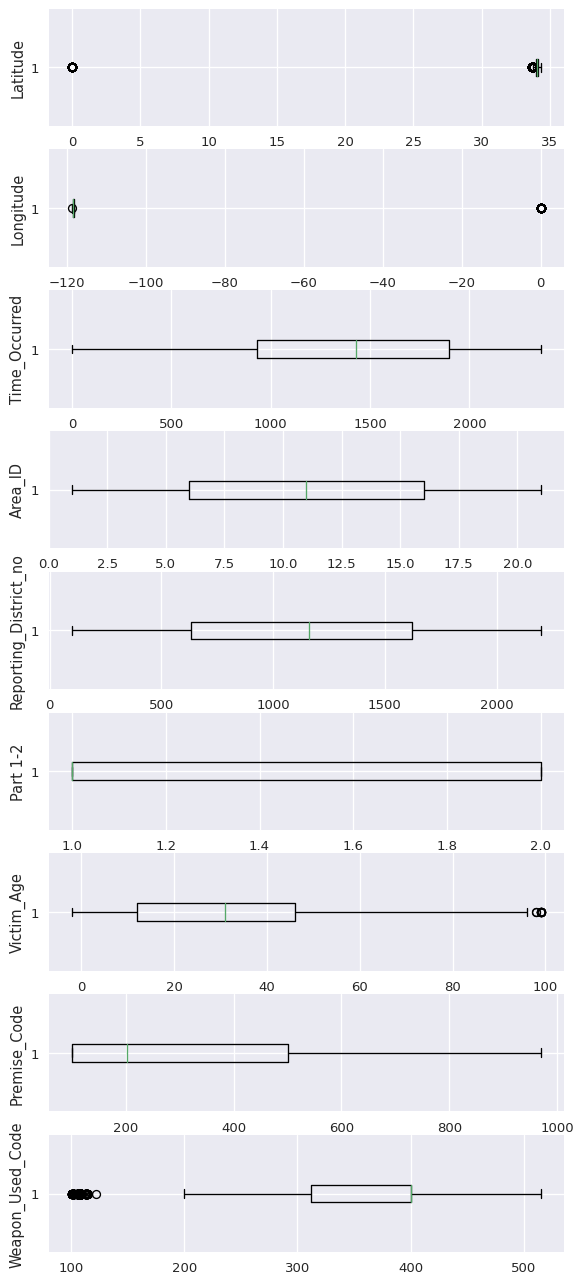

In [10]:
fig, axs = plt.subplots(9,1,dpi=95, figsize=(7,17))
i = 0
for col in train.select_dtypes('number').columns:
    axs[i].boxplot(train[col].dropna(), vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

# We can clearly see that Victim Age has outliers. We can handle the outliers in the feature engineering section.
# Also Latitude and Longitude have outliers. The Latitude and Longitude values are set to 0 instead of NaN. We can handle this in the feature engineering section.

### Checking for Missing Data

In [11]:
# Lets check the number of null values in each column
train.isnull().sum()
# There are Null values in the dataset.

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [12]:
# Columns with missing values
missing_columns = train.columns[train.isnull().any()]
missing_columns
# Possibility that not all crimes did not occurred on Cross Street, therefore is NaN.

Index(['Cross_Street', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent',
       'Premise_Description', 'Weapon_Used_Code', 'Weapon_Description'],
      dtype='object')

In [13]:
# Missing Values Percentage
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(train) * 100
missing_values

# Cross_Street column has 82.76% missing values. Followed by Weapon used 63.325%.


Cross_Street           82.760
Modus_Operandi         13.705
Victim_Sex             13.120
Victim_Descent         13.120
Premise_Description     0.025
Weapon_Used_Code       63.325
Weapon_Description     63.325
dtype: float64

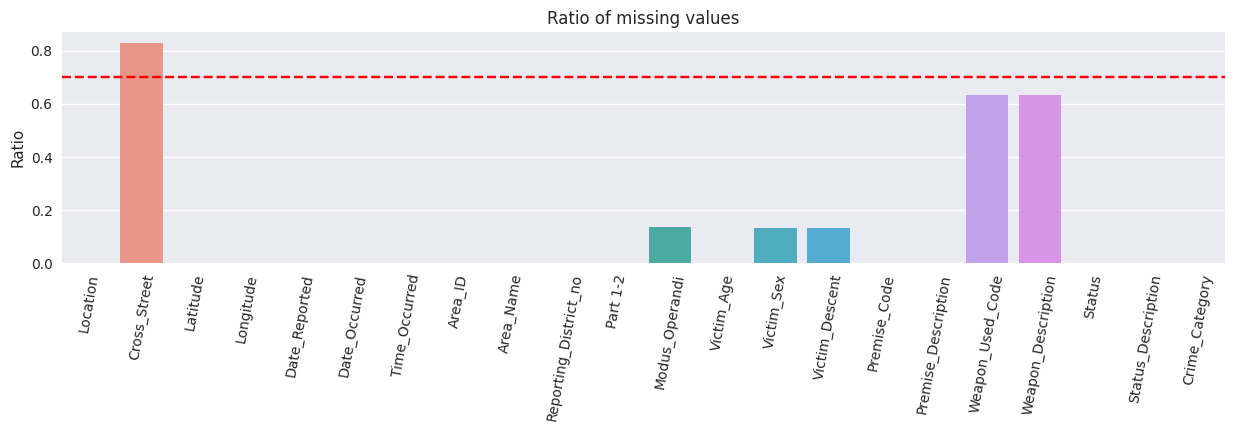

In [14]:
# Plotting the graph of missing values in columns with a threshold value of 0.7
plt.figure(figsize=(15, 3))
null_records = train.isnull().sum()/len(train)
sns.barplot(x=null_records.index, y=null_records.values)
plt.axhline(y = 0.7, color = 'r', linestyle = 'dashed')
plt.xticks(rotation=80)
plt.title('Ratio of missing values')
plt.ylabel('Ratio')
plt.show()

### Data Cleaning and Preprocessing
<!-- <img src="attachment:5079a5f5-f9f8-4c0d-b85a-1d8cc31dcdd8.png" width="25%"></img> -->

In [15]:
# Checking if duplicated records exists
train[train.duplicated()].shape[0]

13

In [16]:
# There are 11 duplicated records in the dataset. We will remove these records from the dataset.
# There might be possiblity that multiple victims are there for the same crime. In that case we can avoid dropping it.
train.drop_duplicates(inplace=True)

#### Latitude and Longitude

In [17]:
# It’s important to point that some location fields with missing data are noted as (0°, 0°)
train[['Latitude', 'Longitude']].value_counts()[0:5]

Latitude  Longitude
0.0000     0.0000      78
34.1883   -118.6274    26
34.2440   -118.5583    23
34.0600   -118.4200    19
34.1030   -118.3225    18
Name: count, dtype: int64

In [18]:
# We will replace the missing values with the median of the respective columns
lat_col = train['Latitude'][train['Latitude'] != 0]
long_col = train['Longitude'][train['Longitude'] != 0]
train['Latitude'] = train['Latitude'].replace(0, lat_col.median())
train['Longitude'] = train['Longitude'].replace(0, long_col.median())

#### Victim Age less than or equal to 0

In [19]:
train[train['Victim_Age'] < 0].shape[0]

6

In [20]:
train[train['Victim_Age'] <= 0].shape[0]

4825

Observations:
1. The minimum value of Victim Age is 0 and -1.
> 1. Approach 1: It is not possible. We will replace it with the median value. We can easily remove this value using the function drop by setting a rule to remove specific values.
> 2. Approach 2: May be indication that victim is not present. We can create a separate column Victim_Involved to know where in a crime victim is present or not.


We can go with Approach 2 of using it as a separted feature

In [21]:
 train['Victim_Involved'] = train['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)

Or we can replace with median age

In [22]:
# We will replace the missing values with the median of the respective columns
train[train['Victim_Age']<=0]['Victim_Age'] = train['Victim_Age'].median()

In [23]:
# Removing the values below one for the "Victim_Age" column
train.drop(train[train['Victim_Age'] <= 0].index, axis=0, inplace=True)

In [24]:
train[train['Victim_Sex']=='H'].head()

Location Cross_Street  Latitude  \
4970   1500 E  112TH                        ST          NaN   33.9332   
16290  1600 W  2ND                          ST          NaN   34.0613   

       Longitude           Date_Reported           Date_Occurred  \
4970   -118.2485  05/18/2020 12:00:00 AM  05/17/2020 12:00:00 AM   
16290  -118.2638  01/03/2020 12:00:00 AM  01/03/2020 12:00:00 AM   

       Time_Occurred  Area_ID  Area_Name  Reporting_District_no  Part 1-2  \
4970          1630.0     18.0  Southeast                 1846.0       2.0   
16290         2200.0      2.0    Rampart                  237.0       2.0   

       Modus_Operandi  Victim_Age Victim_Sex Victim_Descent  Premise_Code  \
4970   1822 0100 0930        36.0          H              B         502.0   
16290            0329        25.0          H              F         103.0   

                                Premise_Description  Weapon_Used_Code  \
4970   MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)               NaN   
16290                                         ALLEY               NaN   

      Weapon_Description Status Status_Description  \
4970                 NaN     IC        Invest Cont   
16290                NaN     IC        Invest Cont   

                      Crime_Category  Victim_Involved  
4970   Fraud and White-Collar Crimes                1  
16290                Property Crimes                1

In [25]:
# We can either remove these rows or replace them with the most common value. We will replace them with the most common value.
train['Victim_Sex'].replace('H', 'M', inplace=True)

In [26]:
# We can also handle the outliers in the Victim_Age column but it will remove records from the dataset which might lead to poor generalisation.
Q1 = train['Victim_Age'].quantile(0.25)
Q3 = train['Victim_Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# train = train[(train['Victim_Age'] > lower_bound) & (train['Victim_Age'] < upper_bound)]

### Analyzing dataset based on Victim
We will consider Victim age, sex and descent.

In [27]:
train['Victim_Descent'].value_counts(sort=True)

Victim_Descent
H    6037
W    3959
B    2862
O    1368
A     419
X     289
K      82
C      51
F      48
J      16
I      11
V       8
P       4
Z       3
U       2
D       1
G       1
Name: count, dtype: int64

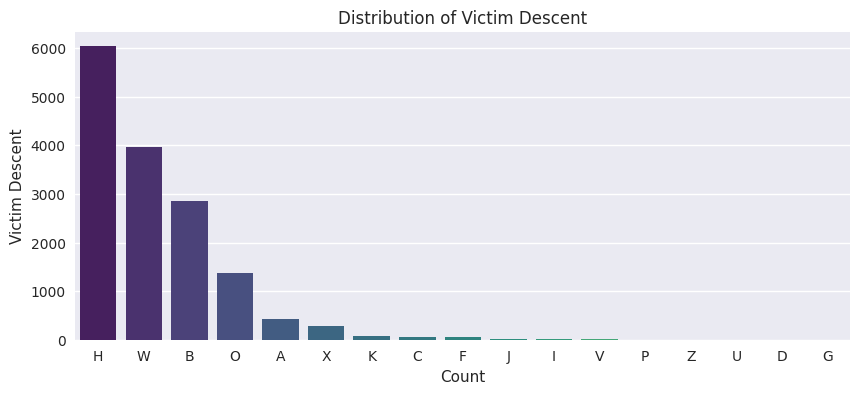

In [28]:
# Lets visualize this data. We find that the most common victim descent is 'H' followed by 'W' and 'B'.
# This lead us to infer that most of the crime victims are belonging to specific descent.
plt.figure(figsize=(10, 4))
sns.countplot(x='Victim_Descent', data=train, order=train['Victim_Descent'].value_counts().index, palette='viridis')
plt.title('Distribution of Victim Descent')
plt.xlabel('Count')
plt.ylabel('Victim Descent')
plt.show()

In [29]:
train['Victim_Age'].value_counts(sort=False, bins=10)

(1.9020000000000001, 11.7]     147
(11.7, 21.4]                  1340
(21.4, 31.1]                  3962
(31.1, 40.8]                  3262
(40.8, 50.5]                  2689
(50.5, 60.2]                  2019
(60.2, 69.9]                  1071
(69.9, 79.6]                   505
(79.6, 89.3]                   123
(89.3, 99.0]                    44
Name: count, dtype: int64

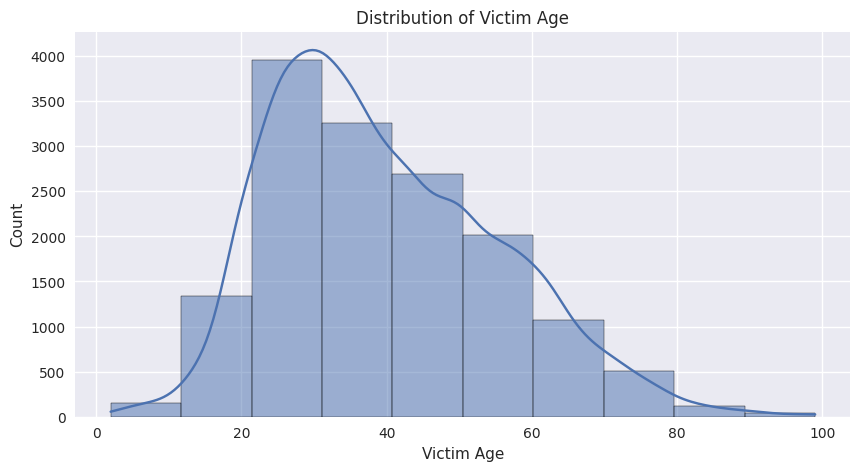

In [30]:
# Lets visualize this data. We find that the most common victim age is between 20 and 30 years.
plt.figure(figsize=(10, 5))
sns.histplot(train['Victim_Age'], bins=10, kde=True)
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Count')
plt.show()

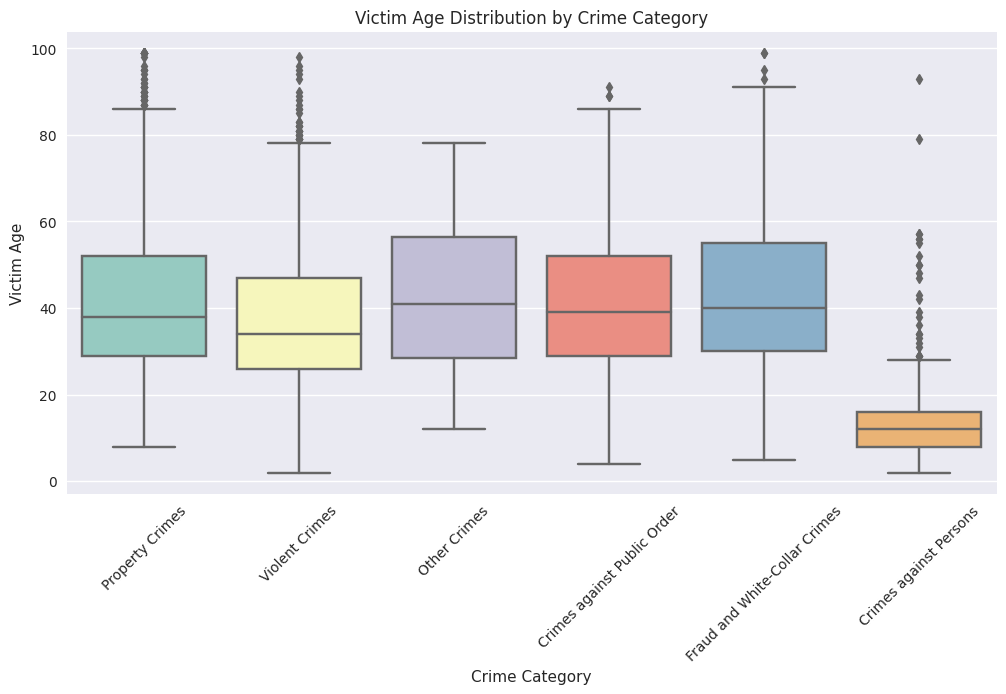

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crime_Category', y='Victim_Age', data=train, palette='Set3')
plt.title('Victim Age Distribution by Crime Category')
plt.xlabel('Crime Category')
plt.ylabel('Victim Age')
plt.xticks(rotation=45)
plt.show()
# Crimes like Violent crime, against public order and white collar crime have relatively higher IQR victim age.

In [32]:
train['Victim_Sex'].value_counts(sort=True)

Victim_Sex
M    7900
F    7098
X     163
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Victim_Sex'>

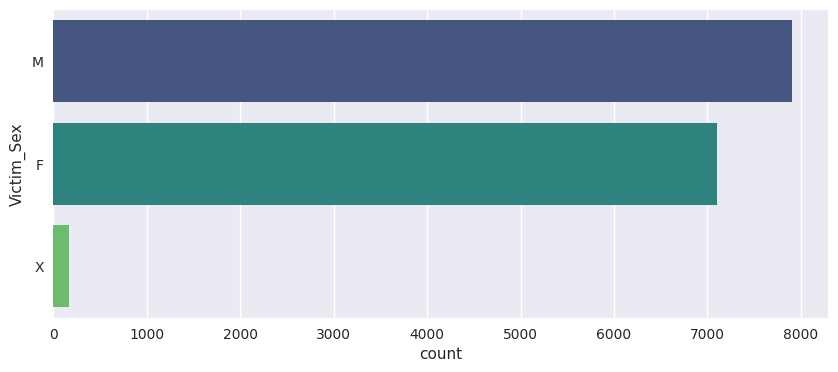

In [33]:
# We find most common victim is Male but the difference is not much. There are two other categories as well 'X' and 'H'. 'X' is unknown and 'H' is other.
plt.figure(figsize=(10, 4))
sns.countplot(y='Victim_Sex', data=train, order=train['Victim_Sex'].value_counts().index, palette='viridis')

# We already replace 'H' with 'M' in earlier steps.

#### Plotting the pie chart for top 3 gender categories

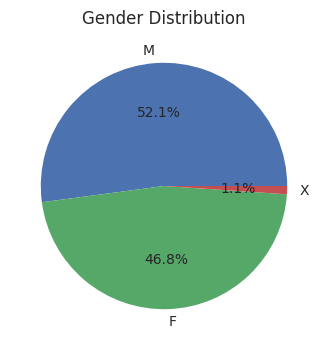

In [34]:
plt.figure(figsize=(10, 4))

train['Victim_Sex'].value_counts()[:3].plot(
    kind='pie', autopct='%0.001f%%')
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()


### Analysis based on Crime Details

In [35]:
# Let's see the top 10 weapons used in the crimes
# train['Weapon_Used_Code'].value_counts(sort=True)
train[['Weapon_Used_Code','Weapon_Description']].value_counts(sort=True)[:10]

Weapon_Used_Code  Weapon_Description                            
400.0             STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    3808
500.0             UNKNOWN WEAPON/OTHER WEAPON                        660
511.0             VERBAL THREAT                                      520
102.0             HAND GUN                                           344
200.0             KNIFE WITH BLADE 6INCHES OR LESS                   149
109.0             SEMI-AUTOMATIC PISTOL                              125
207.0             OTHER KNIFE                                        121
106.0             UNKNOWN FIREARM                                    106
307.0             VEHICLE                                             80
512.0             MACE/PEPPER SPRAY                                   79
Name: count, dtype: int64

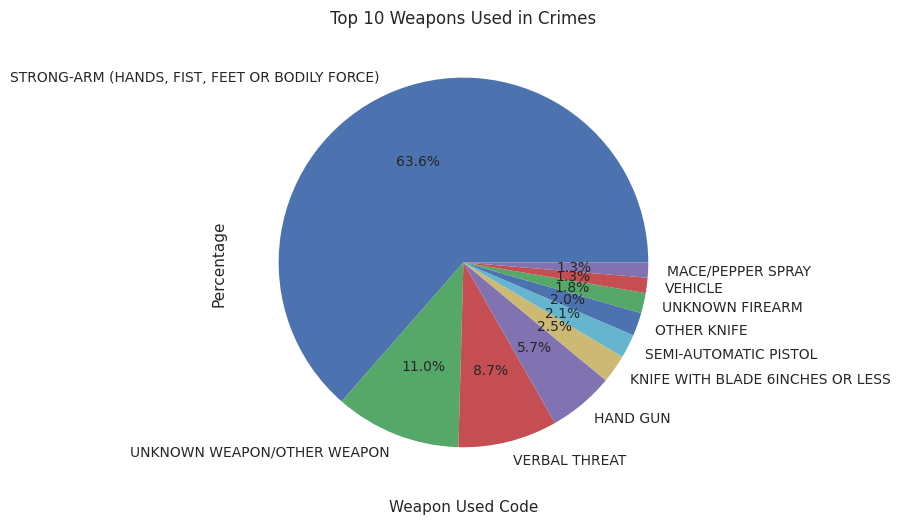

In [36]:
# Let's create a pie chart to visualize the top 10 weapons used in the crimes
plt.figure(figsize=(10, 6))
train['Weapon_Description'].value_counts(sort=True)[:10].plot(kind='pie', autopct='%0.001f%%')
plt.title('Top 10 Weapons Used in Crimes')
plt.xlabel('Weapon Used Code')
plt.ylabel('Percentage')
plt.show()


In [37]:
# Lets check if weapon used code and weapon description are same
# train[['Weapon_Used_Code', 'Weapon_Description']].value_counts()

### Analysis based on Crime Location


In [38]:
import plotly.express as px
fig = px.scatter_mapbox(
    train,
    lat='Latitude',
    lon='Longitude',
    color='Crime_Category',
    hover_name='Location',
    hover_data=['Date_Occurred', 'Time_Occurred', 'Area_Name'],
    title='Crime Incidents Map',
    mapbox_style='carto-positron',
    zoom=10,
    height=600
)
fig.show()


In [39]:
train['Location'].value_counts(sort=True)

Location
VERMONT                      AV            29
6TH                                        29
7TH                                        28
6TH                          ST            25
HOLLYWOOD                                  22
                                           ..
3700    EXPOSITION                   BL     1
7500    GOODLAND                     AV     1
5700    WILSHIRE                     BL     1
800 N  ALFRED                       ST      1
5100 W  ADAMS                        BL     1
Name: count, Length: 10157, dtype: int64

In [40]:
train['Location'] = train['Location'].replace('  +',' ',regex=True)

In [41]:
train['Cross_Street'].value_counts(sort=True)

Cross_Street
BROADWAY                           42
VERMONT                      AV    34
FIGUEROA                           34
FIGUEROA                     ST    29
SAN PEDRO                          25
                                   ..
CRYSTAL                      ST     1
E  ORLANDO                          1
D                            ST     1
CABRILLO                     AV     1
HAVELOCK                            1
Name: count, Length: 1256, dtype: int64

In [42]:
train['Cross_Street'] = train['Cross_Street'].replace(' +', ' ', regex=True)

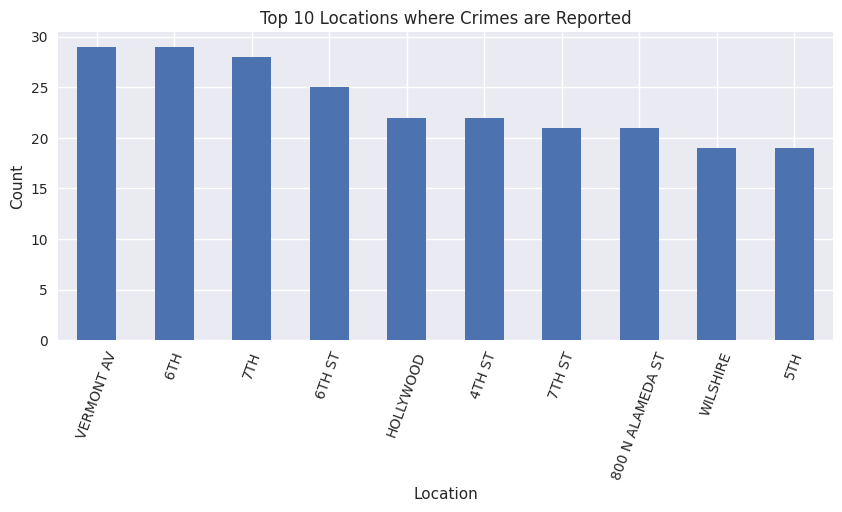

In [43]:
# Plotting graph for top 10 locations where crimes are reported
plt.figure(figsize=(10, 4))
train['Location'].value_counts(sort=True)[:10].plot(kind='bar')
plt.title('Top 10 Locations where Crimes are Reported')
plt.xlabel('Location')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.show()

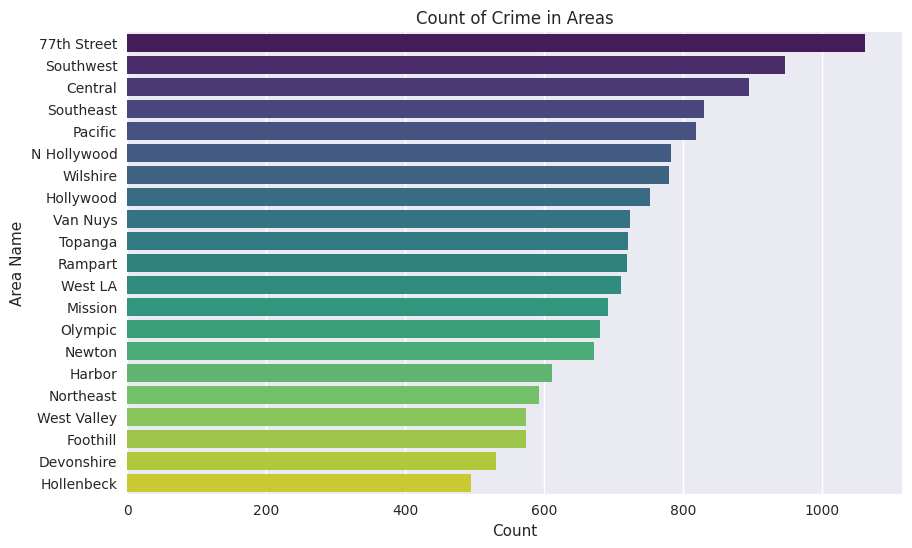

In [44]:
# Let's visualize the top 10 areas where crimes are reported
plt.figure(figsize=(10, 6))
sns.countplot(y='Area_Name', data=train, order=train['Area_Name'].value_counts().index, palette='viridis')
plt.title('Count of Crime in Areas')
plt.xlabel('Count')
plt.ylabel('Area Name')
plt.show()

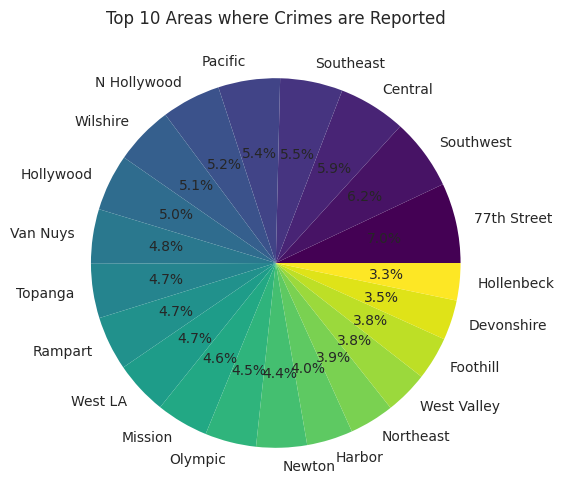

In [45]:
# Pie chart for top 10 areas where crimes are reported
plt.figure(figsize=(10, 6))
train['Area_Name'].value_counts().plot(kind='pie', autopct='%0.001f%%', colormap='viridis')
plt.title('Top 10 Areas where Crimes are Reported')
plt.ylabel('')
plt.show()

#### Crime categories distribution for each area
Individual crime distribution for each area

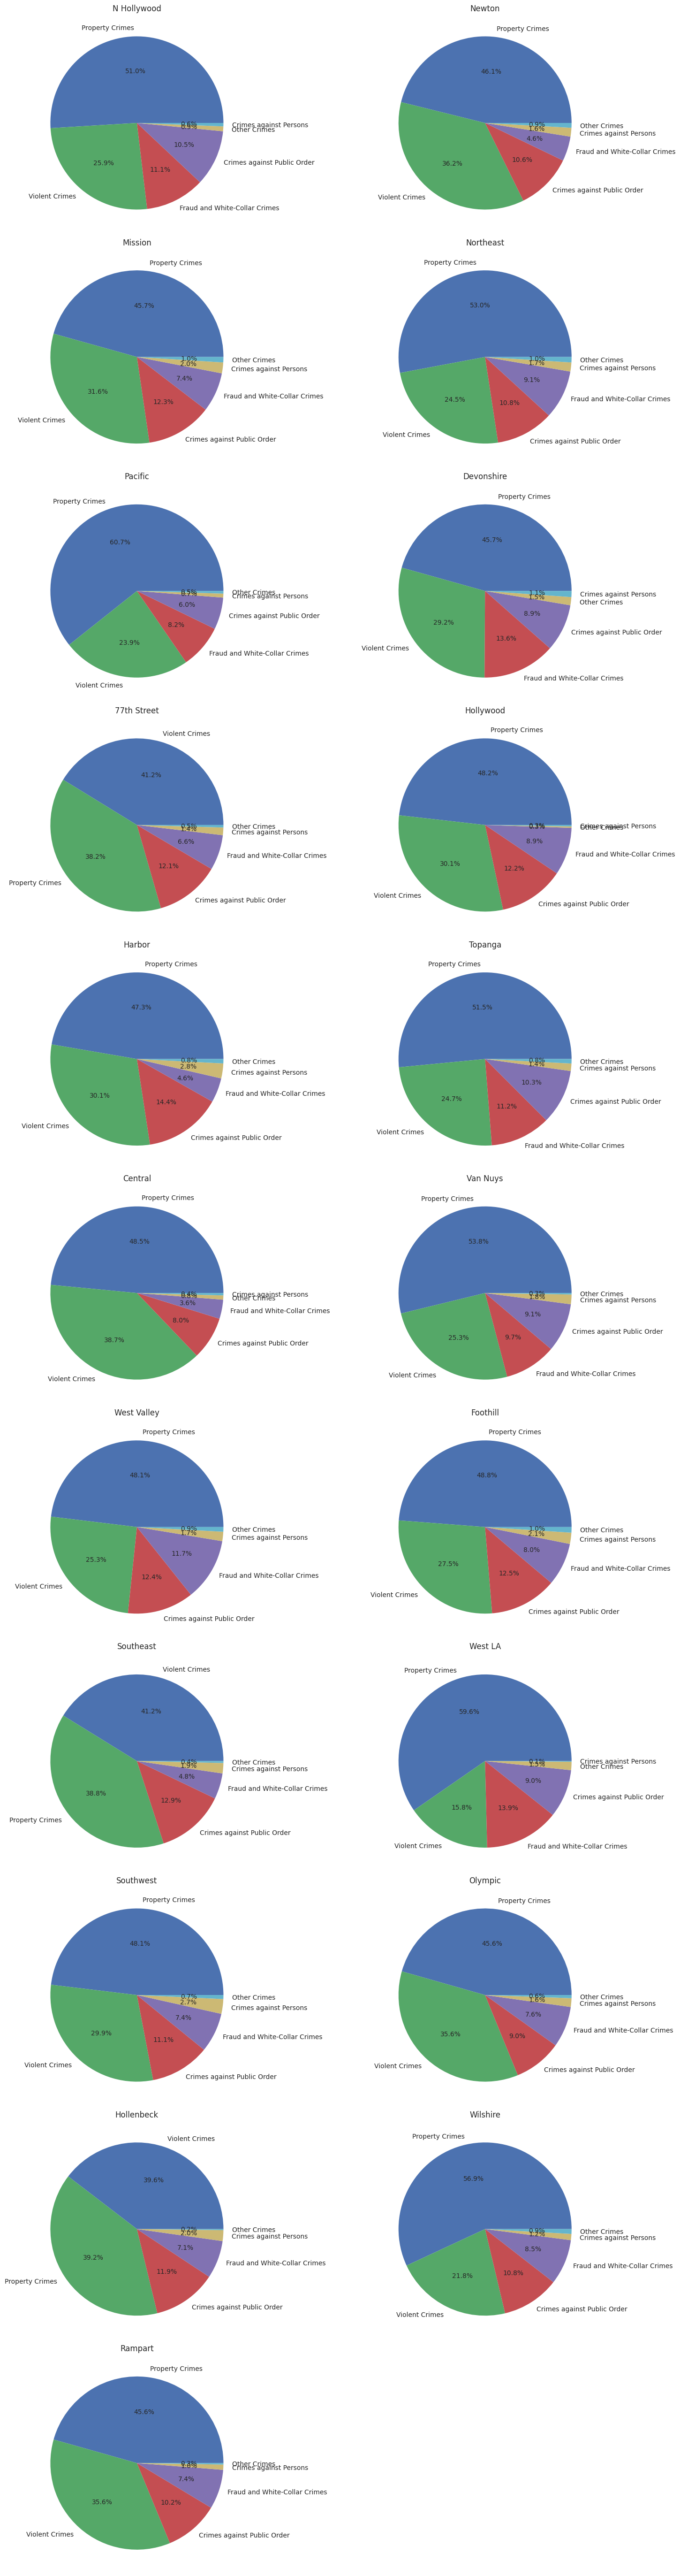

In [46]:
num_areas = len(train['Area_Name'].unique())
fig, axes = plt.subplots(nrows=int(num_areas / 2) + (num_areas % 2), ncols=2, figsize=(15, 5 * (num_areas // 2 + 1)))
axes = axes.flatten()

# Loop through each area and plot a pie chart on a separate subplot
for idx, area in enumerate(train['Area_Name'].unique()):
    crime_counts = train[train['Area_Name'] == area]['Crime_Category'].value_counts()
    axes[idx].pie(crime_counts, labels=crime_counts.index, autopct='%0.1f%%')
    axes[idx].set_title(area)

# Hide any unused subplots (if number of areas is odd)
for j in range(len(train['Area_Name'].unique()), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Observations:
1. While for most of the areas, the crime distribution seems like they are same. Property crimes is the leading category for each of the district but we have to understand that in our dataset Property crimes is the most leading category.
2. For some areas like `77th Street`, `South East`, `Hollenbeck` have relative larger counts of Violent Crimes.
3. For areas like `Devoshrire` and `Pacific`, the percentage of `Fraud and White-Collar Crimes` is higher than `Crimes against Public Order` as contrast to other areas.

#### Distribution of Crime Categories

In [47]:
train['Crime_Category'].value_counts(sort=True)

Crime_Category
Property Crimes                  7363
Violent Crimes                   4621
Crimes against Public Order      1614
Fraud and White-Collar Crimes    1238
Crimes against Persons            215
Other Crimes                      111
Name: count, dtype: int64

### Data is highly imbalanced

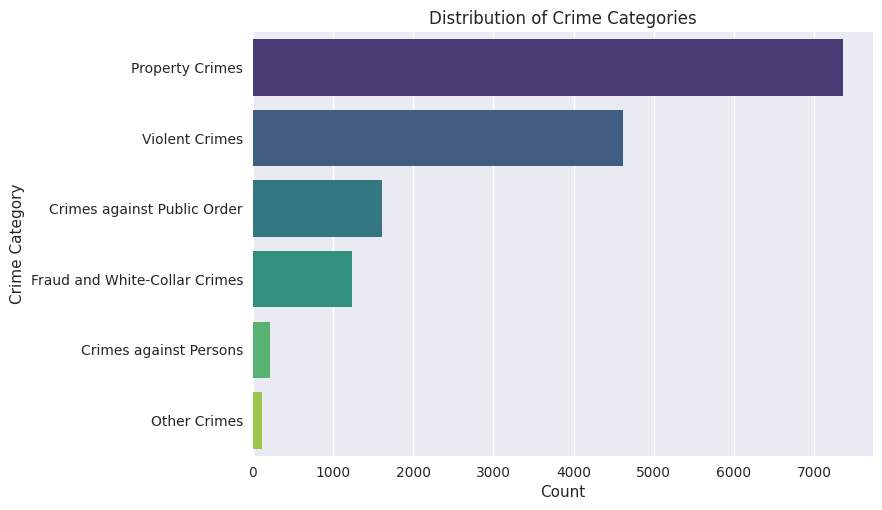

In [48]:
sns.countplot(y='Crime_Category', data=train, order=train['Crime_Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Crime Categories')
plt.xlabel('Count')
plt.ylabel('Crime Category')
plt.show()

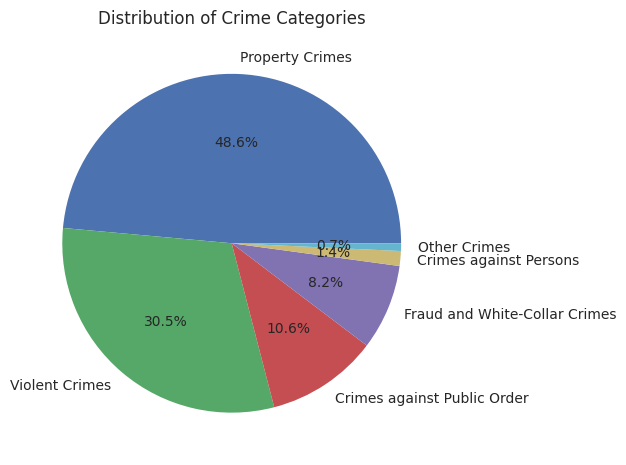

In [49]:
# Distribution of crime categories for the training dataset
train['Crime_Category'].value_counts(sort=True).plot(kind='pie', autopct='%0.001f%%')
plt.title('Distribution of Crime Categories')
plt.ylabel('')
plt.show()

> Distribution of Victim age for each crime category

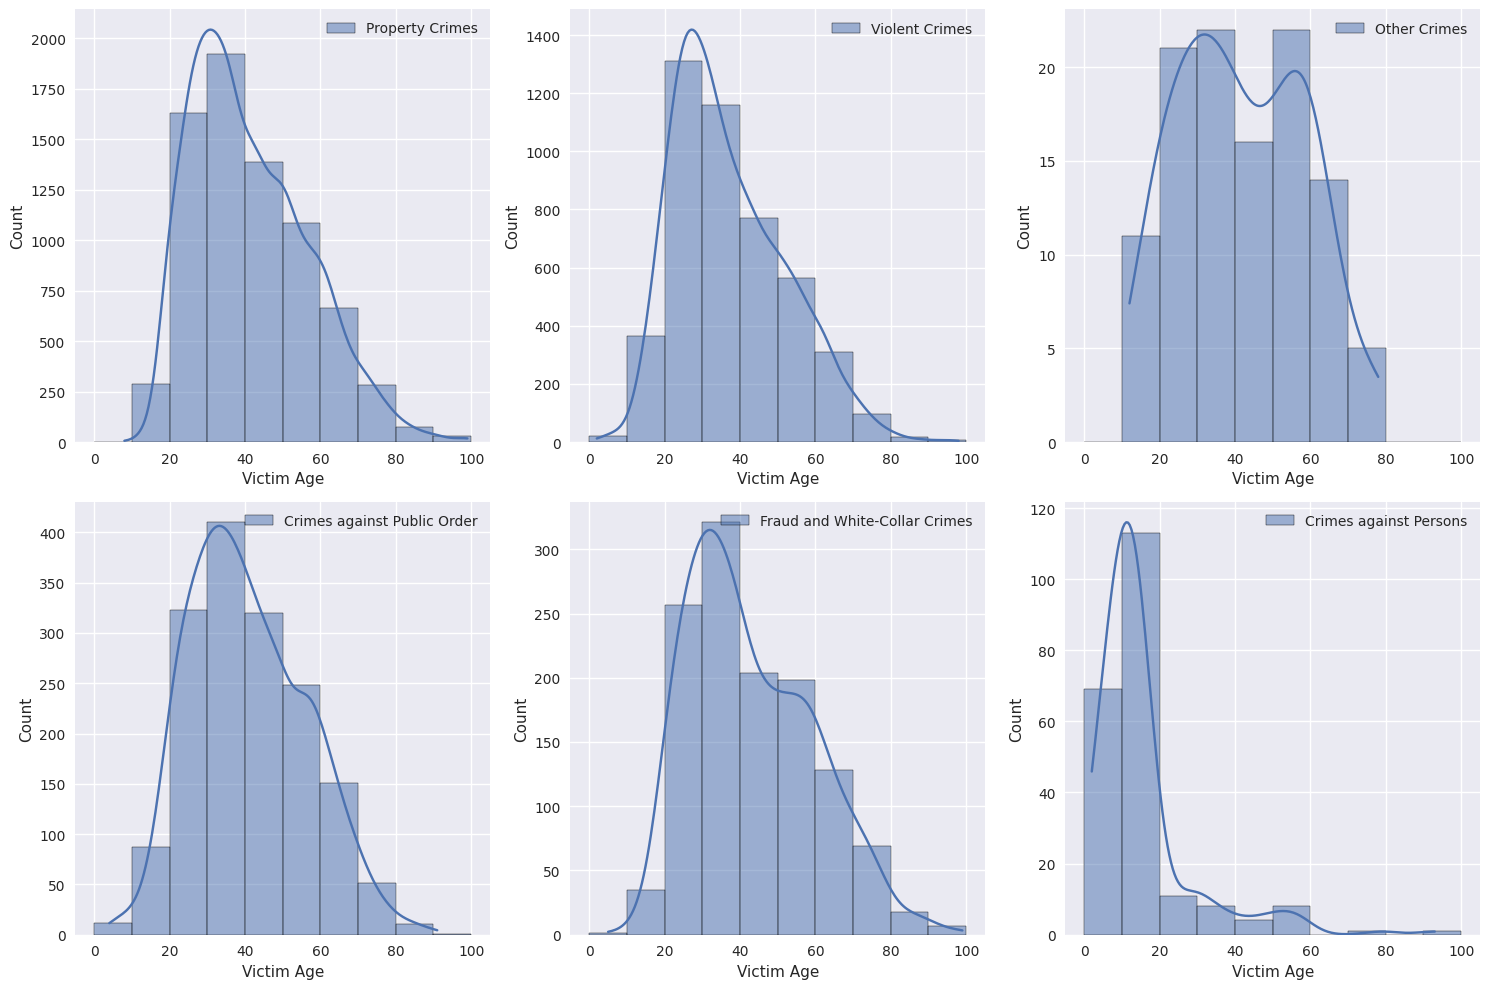

In [50]:
categories = train['Crime_Category'].unique()
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, category in enumerate(categories):
    row = i // 3
    col = i % 3

    # Plot between Victim_Age and Crime_Category
    sns.histplot(train[train['Crime_Category'] == category]['Victim_Age'], kde=True, label=category, ax=axs[row, col], palette='viridis', bins=10,  binrange=(0, 100))
    axs[row, col].set_xlabel('Victim Age')
    axs[row, col].set_ylabel('Count')
    axs[row, col].legend()
plt.tight_layout()
plt.show()



Observations:
1. Victim Age is an important feature in predicting the crime category. We can see that the distribution of victim age varies for different crime categories.
2. For example, the property crime category has a higher number of victims in the age group of 20-50 years.
3. Similarly, the violent crime category has a higher number of victims in the age group of 20-40 years.
4. Crime Against persons has a higher number of victims in the age group of 0-20 years.
5. Crime Against public order and white collar crimes has similar distribution.

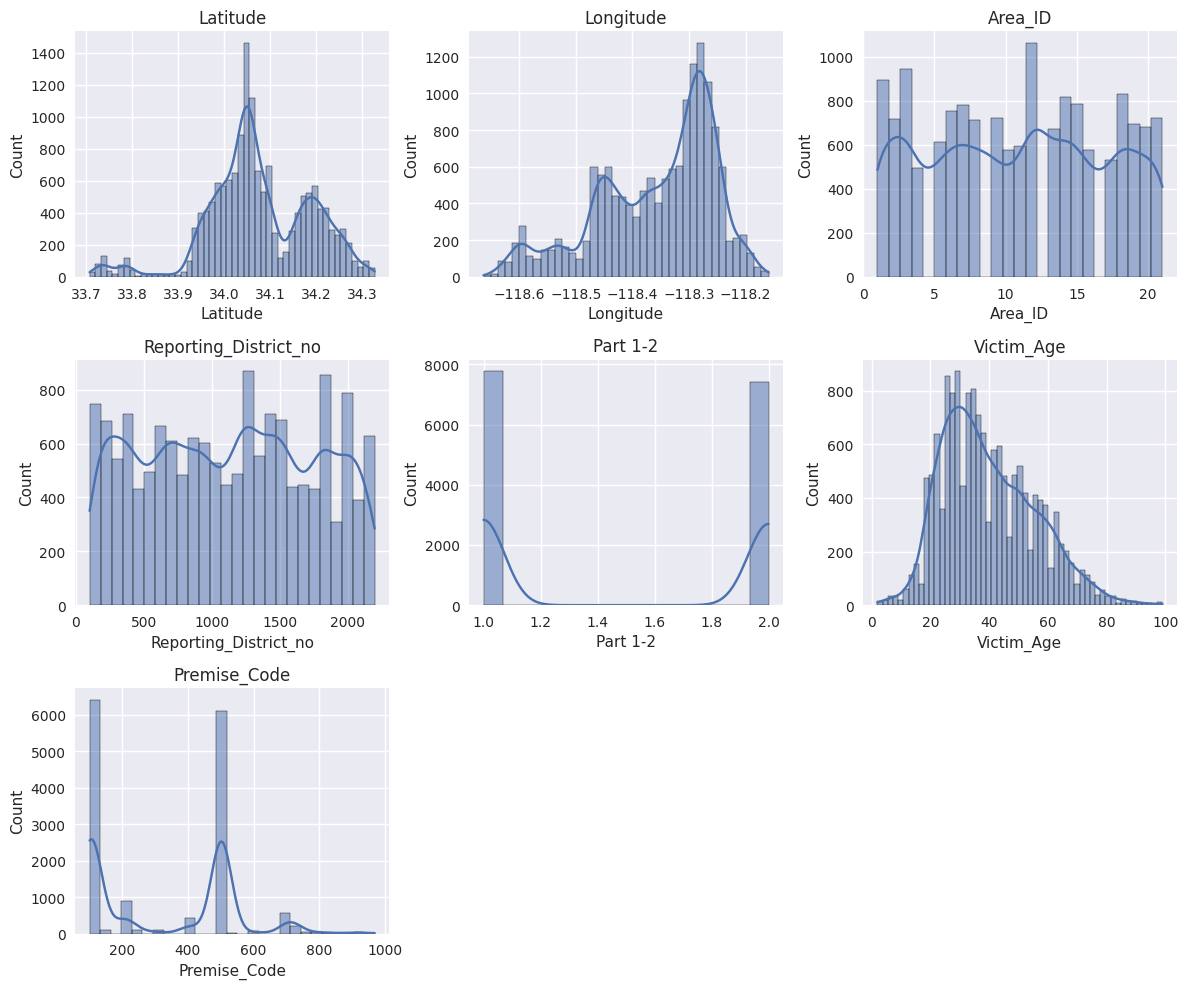

In [51]:
# Visualize the distribution of numeric variables
numeric_cols = ["Latitude", "Longitude", "Area_ID", "Reporting_District_no", "Part 1-2", "Victim_Age", "Premise_Code"]
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(train[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()
# Plot of premise code shows that most crimes occur for few specific code only

In [52]:
value_counts = train['Premise_Code'].value_counts()

top_5 = value_counts.head(5)

total_count = value_counts.sum()
top_5_percentages = (top_5 / total_count) * 100

print(top_5_percentages)
print(len(value_counts))
# Out of 204 premise code top 5 premise accounts for around 65%.

Premise_Code
501.0    21.975993
101.0    18.691466
502.0    15.552038
108.0     6.377787
102.0     6.021633
Name: count, dtype: float64
204


In [53]:
# train[train['Victim_Age']==0]['Crime_Category'].value_counts()
# Victim age is 0 for large number of crimes.
# We can either remove these records or replace them with the most common value. We will replace them with the most common value. Or can keep as it is -> create a new feature that victim is not present.

### Analysis based on when crime took place
#### Crimes count v/s Time (Hour of day) Occurred

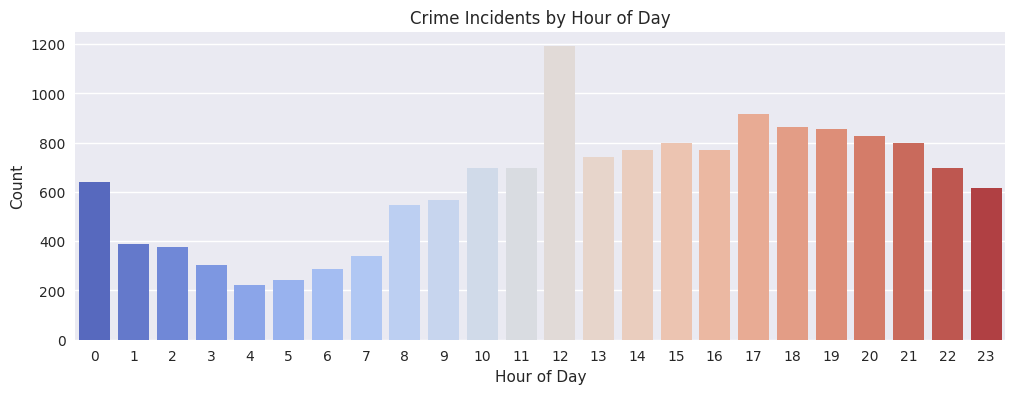

In [54]:
# Extract hour from the Time_Occurred column
train['Hour_Occurred'] = (train['Time_Occurred'] // 100).astype(int)

plt.figure(figsize=(12, 4))
sns.countplot(x='Hour_Occurred', data=train, palette='coolwarm')
plt.title('Crime Incidents by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

# Observations:
# Most of the crimes occur during the day time between 12 PM and 6 PM.
# The least number of crimes occur during the early morning hours between 12 AM and 6 AM.

<Figure size 600x300 with 0 Axes>

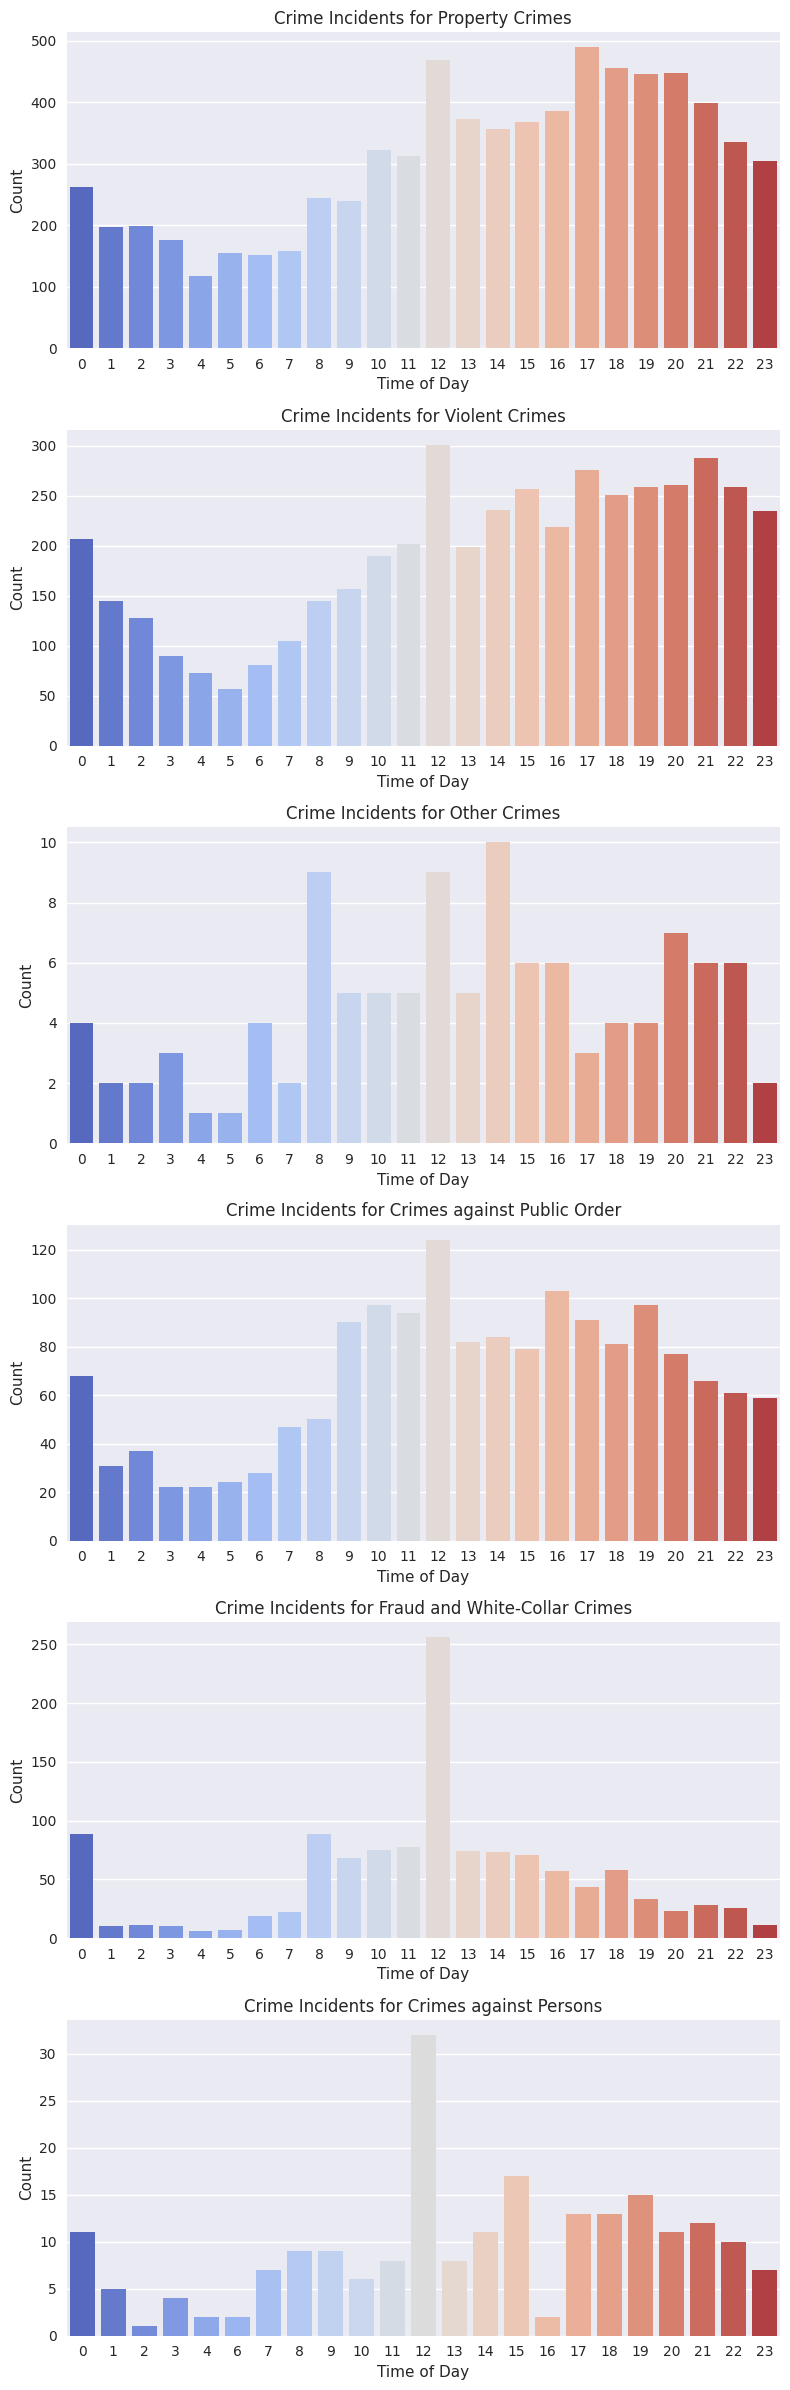

In [55]:
# Plotting each crime category counts vs the hour of the day

plt.figure(figsize=(6, 3))
fig, axs = plt.subplots(len(train['Crime_Category'].unique()), 1, figsize=(8, 4 * len(train['Crime_Category'].unique())))

for i, category in enumerate(train['Crime_Category'].unique()):
    sns.countplot(x='Hour_Occurred', data=train[train['Crime_Category'] == category], palette='coolwarm', ax=axs[i])
    axs[i].set_title(f'Crime Incidents for {category}')
    axs[i].set_xlabel('Time of Day')
    axs[i].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

plt.show()
# Observations:
# Not all crime categories have the same distribution of crime incidents by hour of day.

#### Crimes count v/s Day Occurred

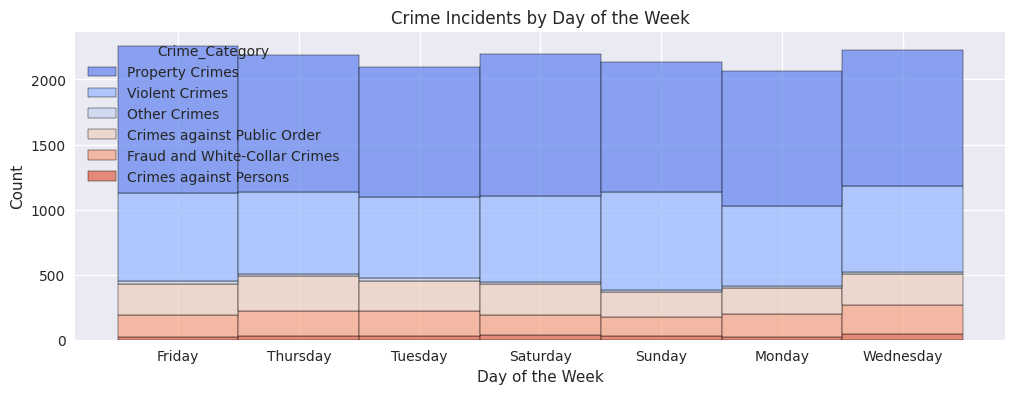

In [56]:
# Convert Date_Occurred to datetime and extract the day of the week
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])
train['Day_of_Week'] = train['Date_Occurred'].dt.day_name()

plt.figure(figsize=(12, 4))
sns.histplot(x='Day_of_Week', data=train, palette='coolwarm', hue="Crime_Category", multiple="stack")
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

# Observations:
# Most of the crimes occur on Friday and Saturday but the difference is not that much.
# We can ignore the day of the week as it does not have much impact on the crime incidents.


#### Crimes count v/s Month Occurred

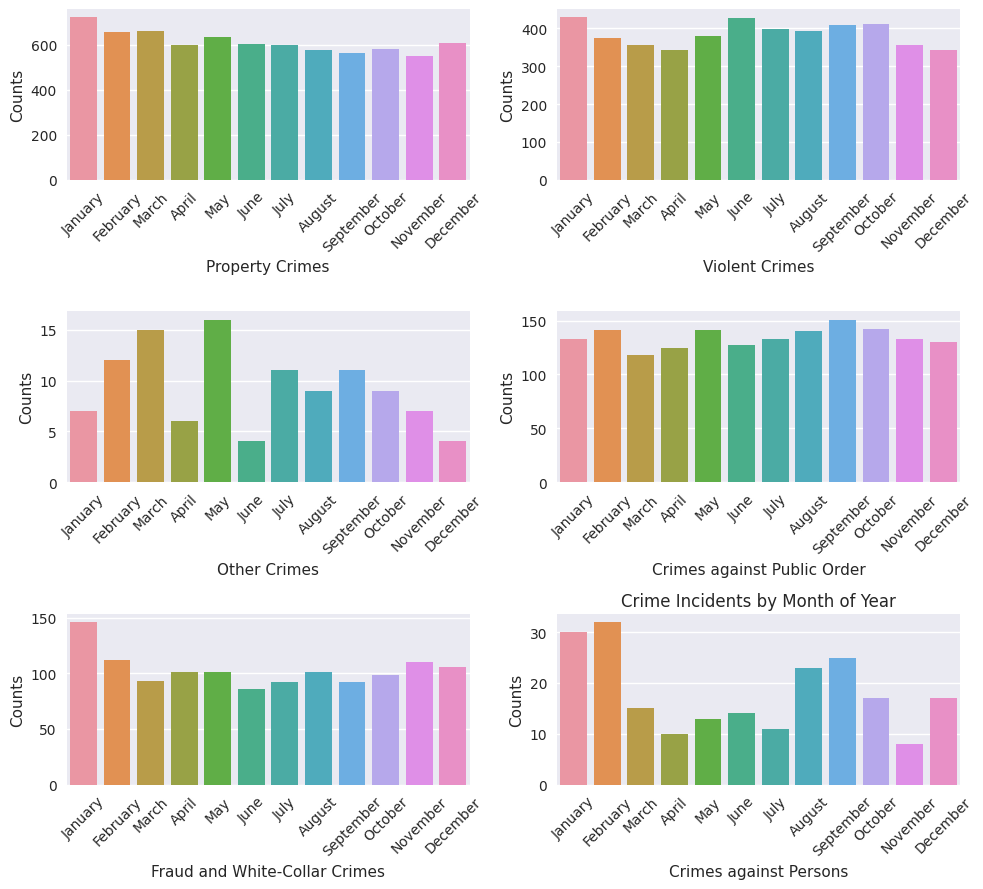

In [57]:
train['Month_Occurred'] = train['Date_Occurred'].dt.month_name()
num_categories = train['Crime_Category'].nunique()

fig, axs = plt.subplots((num_categories + 1) // 2, 2, figsize=(10, 3 * ((num_categories + 1) // 2)))

# Flatten the axs array for easy indexing
axs = axs.flatten()

for i, category in enumerate(train['Crime_Category'].unique()):
    sns.countplot(x='Month_Occurred', data=train[train['Crime_Category'] == category], ax=axs[i], order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
    axs[i].set_xlabel(f'{category}')
    axs[i].set_ylabel('Counts')
    axs[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.title('Crime Incidents by Month of Year')
# Adjust the spacing between subplots
plt.tight_layout()

plt.show()

# Observations:
# The counts of crime incidents by month of year vary across different crime categories.
# For example, crimes like Property, Violent, and against public order have uniform distribution across all months but other crimes have higher counts in starting months of the year.

### Correlation Matrix - Numeric columns only

We check the correlation of the numerical features with the target feature

<Axes: >

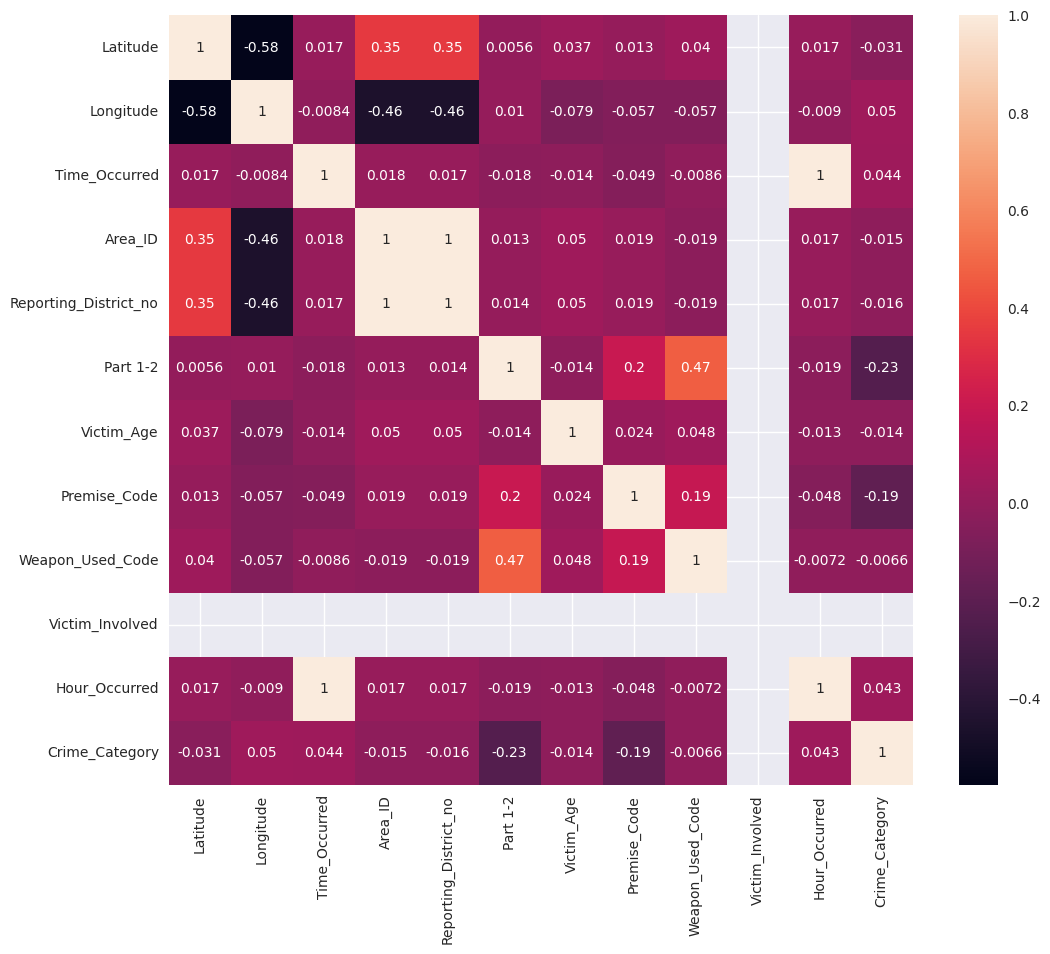

In [58]:
le = LabelEncoder()
plt.figure(figsize=(12, 10))
numeric_columns = list(train.select_dtypes('number').columns)
label_crime_category = le.fit_transform(train.loc[:,'Crime_Category'])
num_feat_cor = train.loc[:,numeric_columns]
numeric_columns.append('Crime_Category')
num_cor = pd.DataFrame(np.hstack((num_feat_cor, label_crime_category.reshape(-1,1))), columns = numeric_columns)
sns.heatmap(num_cor.corr(), annot=True)
# Some high correlated features
# Latitude and Longitude and Area ID and District no
# Part 1-2 and Weopon used and Premise code
# Crime category and Part 1-2 and Premise Code
# We can remove either Area ID or District no

Using seaboarn to plot same heatmap

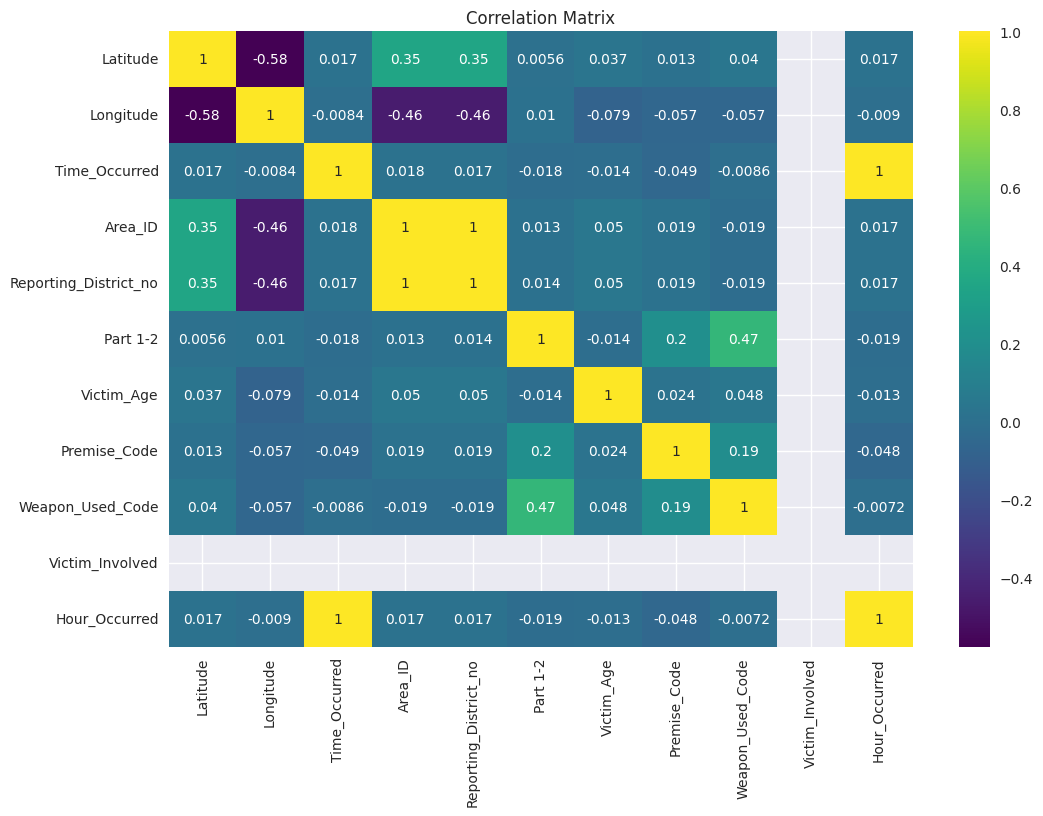

In [59]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train.select_dtypes('number').corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

### Feature Transformation & Feature Creation

In [60]:
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'])

In [61]:
# Let create new columns for the hour of day day of the week, month and year when the crime occurred

train['Day_of_Week'] = train['Date_Occurred'].dt.dayofweek
train['Month_Occurred']=pd.to_datetime(train['Date_Reported']).dt.month
train['Year_Occurred'] = train['Date_Occurred'].dt.year

### Train test split

In [62]:
# Extracting the features and target columns
train, test = load_dataset(running_env)
X = train.drop('Crime_Category', axis=1)
y = train['Crime_Category']

In [63]:
# Creating a training and test data with 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Dummy Classifier (Baseline Model)

In [64]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy= "most_frequent")
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.57575

### Data Preprocessing
<!-- ![image.png](attachment:image.png) -->


1. Converting float to integer types.
2. Transforming Modus_Operandi feature

In [65]:
train['Part 1-2'] = train['Part 1-2'].astype(int)
train['Reporting_District_no'] = train['Reporting_District_no'].astype(int)
train['Area_ID'] = train['Area_ID'].astype(int)

# Preprocess Modus Operandi column
train['Modus_Operandi_Codes'] = train['Modus_Operandi'].str.split()
train['Modus_Operandi_Codes'] = train['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

In [66]:
train['Modus_Operandi_Codes'][:5]

0                                              [0385]
1    [0906, 0352, 0371, 0446, 1822, 0344, 0416, 0417]
2                                        [0329, 1202]
3                                        [0329, 1300]
4                [0416, 0945, 1822, 0400, 0417, 0344]
Name: Modus_Operandi_Codes, dtype: object

#### Imputing missing values

In [67]:
train[['Weapon_Used_Code','Weapon_Description']][train['Weapon_Used_Code'].notna()].sample(5)
# Since Weapon_Used_Code is smaller for deadlier weapons, we can replace the missing values with the maximum value + 100 in the column.

Weapon_Used_Code                              Weapon_Description
19690             500.0                     UNKNOWN WEAPON/OTHER WEAPON
18022             500.0                     UNKNOWN WEAPON/OTHER WEAPON
2564              500.0                     UNKNOWN WEAPON/OTHER WEAPON
10593             400.0  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)
10173             400.0  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)

In [68]:
train['Weapon_Used_Code'] = train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].max()+100)
train['Victim_Age'] = train['Victim_Age'].fillna(train['Victim_Age'].median())
train['Victim_Descent'] = train['Victim_Descent'].fillna(train['Victim_Descent'].mode()[0])

### New features - Feature engineering
* Victim Arrested: Creates Victim_Arrested, indicating if the status is 'AA' or 'JA', resulting in True for these statuses and False otherwise.
* Occurred on Cross Street: Creates Occurred_on_crossstreet, setting 1 if Cross_Street is present and 0 if it is missing.
* Victim Involved: Creates Victim_Involved, indicating if Victim_Age is greater than 0, resulting in 1 for involved victims and 0 otherwise.
* Days Elapsed to Report: Calculates Days_elpased_to_report as the difference in days between Date_Occurred and Date_Reported.

In [69]:
train['Status'].value_counts()

Status
IC    15236
AO     2597
AA     2054
JA       70
JO       43
Name: count, dtype: int64

In [70]:
# New features - Feature engineering

train['Victim_Arrested'] = train['Status'].apply(lambda status : status == 'AA' or status == 'JA')
train['Occurred_on_crossstreet'] = train['Cross_Street'].apply(lambda x : 0 if x is np.nan else 1)
train['Victim_Involved'] = train['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)
train['Days_elpased_to_report'] = (pd.to_datetime(train['Date_Reported']) - pd.to_datetime(train['Date_Occurred'])).dt.days

### Scaling numerical features.

In [71]:
# Standardize numerical features
numeric_columns = ['Latitude', 'Longitude', 'Victim_Age', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Time_Occurred', 'Victim_Involved',]
scaler = StandardScaler()
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])

### Encoding categorical features.

In [72]:
categoric_columns = ['Status', 'Victim_Descent', 'Victim_Sex']
for column in list(train.columns):
    if column.startswith('Modus_Opernadi'):
        categoric_columns.append(column)

In [73]:
# We will use OneHotEncoder to encode the categorical columns later in this notebook. As of now, we will use LabelEncoder to encode the categorical columns.
le_victim_sex = LabelEncoder()
train['Victim_Sex_Encoded'] = le_victim_sex.fit_transform(train['Victim_Sex'])

le_victim_descent = LabelEncoder()
train['Victim_Descent_Encoded'] = le_victim_descent.fit_transform(train['Victim_Descent'])

Let's create a common function for it and use it

In [74]:
def preprocessing(train_df, test_df):

    # Drop duplicates
    train_df.drop_duplicates(inplace=True)
    # Removing the values less that zero for the "Victim_Age" column
    train_df.drop(train_df[train_df['Victim_Age'] < 0].index, axis=0, inplace=True)

    train_df['Victim_Sex'].replace('H', 'M', inplace=True)

    # Handling the outliers in the Victim_Age column
    Q1 = train['Victim_Age'].quantile(0.25)
    Q3 = train['Victim_Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df['Victim_Age'] > lower_bound) & (train_df['Victim_Age'] < upper_bound)]

    # We will replace the missing values with the median of the respective columns
    lat_col = train_df['Latitude'][train_df['Latitude'] != 0]
    long_col = train_df['Longitude'][train_df['Longitude'] != 0]

    train_df['Latitude'] = train_df['Latitude'].replace(0, lat_col.median())
    train_df['Longitude'] = train_df['Longitude'].replace(0, long_col.median())

    # We will replace the missing values with the median of the respective columns
    lat_col = test_df['Latitude'][test_df['Latitude'] != 0]
    long_col = test_df['Longitude'][test_df['Longitude'] != 0]
    test_df['Latitude'] = test_df['Latitude'].replace(0, lat_col.median())
    test_df['Longitude'] = test_df['Longitude'].replace(0, long_col.median())

    train_df['Hour_Occurred'] = (train_df['Time_Occurred'] // 100).astype(int)
    train_df['Month_Occurred'] = pd.to_datetime(train_df['Date_Reported']).dt.month
    test_df['Hour_Occurred'] = (test_df['Time_Occurred'] // 100).astype(int)
    test_df['Month_Occurred'] = pd.to_datetime(test_df['Date_Reported']).dt.month

    # Preprocess Modus Operandi column
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi'].str.split()
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi'].str.split()
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

    return train_df, test_df


## Pipelines

### Feature extraction and engineering

- Let's create a custom class for transformation on X_Modus_Operandi column

In [75]:
# Defining the custom transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        # used for transforming lists of labels into a binary format (one-hot encoding).
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)


In [76]:
# Creating a helper function to create the model pipeline with preprocessing and modeling steps
def get_model_pipeline(train_data, test_data, model=RandomForestClassifier(n_estimators=100, random_state=42)):

    categorical_features = ['Victim_Sex', 'Victim_Descent', 'Status', 'Location']
    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code']

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent', 'Status']),
            ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])

    # Create and combine preprocessing and modeling pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    return pipeline


## Hyperparameter tuning

#### Hyper Parameter tunning results for XGBoostClassifier:

Best parameters:
`{'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}`


In [77]:
# Hyperparameter tuning using GridSearchCV
def train_model_with_grid_search_cv(train_data, test_data, model=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')):
    train_data, test_data = preprocessing(train_data, test_data)

    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code']

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y.values.reshape(-1,1))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent', 'Status', ]),
            ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])

    # Create and combine preprocessing and modeling pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Define hyperparameter grid
    param_grid = {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1, verbose=2)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print best parameters
    print(f'Best parameters: {grid_search.best_params_}')

    # Evaluate the model
    y_pred = grid_search.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.2f}')

    # Predict on the test data
    test_preds = grid_search.predict(test_data)
    decoded_y_preds = label_encoder.inverse_transform(test_preds)
    return grid_search.best_estimator_

train, test = load_dataset(running_env)

# train_model_with_grid_search_cv(train, test)

# Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
# Validation Accuracy: 0.93

### Making Submission

In [78]:
def make_submission(predictions):
    submission = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'Crime_Category': predictions})
    submission.to_csv('submission.csv', index=False)

### Training a model and making predictions

In [79]:
def train_model(train_data, test_data, pipeline, generate_submission_csv=True):

    train_data, test_data = preprocessing(train_data, test_data)

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y.values.reshape(-1,1))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.5f}')

    if generate_submission_csv:
        # Predict on the test data
        test_preds = pipeline.predict(test_data)
        decoded_y_preds = label_encoder.inverse_transform(test_preds)
        make_submission(decoded_y_preds)

    return pipeline



## Experimenting with Different Models

### Logistic regression with cross-validation.
Tuning the hyperparameters of the model.

Observation:
<hr/>

Best parameters:  `{'classifier__Cs': 5, 'classifier__cv': 3, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'} `
<hr/>


Validation accuracy: ` 0.82675`



In [80]:
from sklearn.model_selection import GridSearchCV

train_data, test_data = load_dataset(running_env)
# Define the hyperparameter grid
param_grid = {
    'classifier__Cs': [1, 5],
    'classifier__cv': [3, 5],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Create the pipeline with the LogisticRegressionCV model
# model=LogisticRegressionCV()
# pipeline = get_model_pipeline(train_data, train_data, model)

# Create the GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid, cv=2, verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the training data
# train_model(train_data, test_data, grid_search, generate_submission_csv=False)

# Print the best parameters and the validation accuracy
# print("Best parameters: ", grid_search.best_params_)
# print("Validation accuracy: ", grid_search.best_score_)


### Training a CART

In [81]:
# Train and evaluate CART
# cart_model = DecisionTreeClassifier(random_state=42)
# cart_model.fit(X_train_scaled, y_train)
# cart_pred = cart_model.predict(X_test_scaled)
# print("CART Accuracy:", accuracy_score(y_test, cart_pred))
# print("\nCART Classification Report:\n", classification_report(y_test, cart_pred))


# Validation Accuracy: 0.927

### Training a Bagging Classifier

In [82]:
# Train and evaluate Bagging
# bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
# bagging_model.fit(X_train_scaled, y_train)
# bagging_pred = bagging_model.predict(X_test_scaled)
# print("\nBagging Accuracy:", accuracy_score(y_test, bagging_pred))
# print("\nBagging Classification Report:\n", classification_report(y_test, bagging_pred))

# Validation Accuracy: 0.9505

### Training a AdaBoost Classifier

In [83]:
# Train and evaluate AdaBoost
# adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
# adaboost_model.fit(X_train_scaled, y_train)
# adaboost_pred = adaboost_model.predict(X_test_scaled)
# print("\nAdaBoost Accuracy:", accuracy_score(y_test, adaboost_pred))
# print("\nAdaBoost Classification Report:\n", classification_report(y_test, adaboost_pred))

# Validation Accuracy: 	0.86

### Training a MLP Classifier

In [84]:
# Train and evaluate MLP Neural Network
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
# mlp_model.fit(X_train_scaled, y_train)
# mlp_pred = mlp_model.predict(X_test_scaled)
# print("\nMLP Accuracy:", accuracy_score(y_test, mlp_pred))
# print("\nMLP Classification Report:\n", classification_report(y_test, mlp_pred))

### Compairing multiple models at once

In [85]:
train, test = load_dataset(running_env)

train['Part 1-2'] = train['Part 1-2'].astype(int)
train['Reporting_District_no'] = train['Reporting_District_no'].astype(int)
train['Area_ID'] = train['Area_ID'].astype(int)

# Preprocess Modus Operandi column
train['Modus_Operandi_Codes'] = train['Modus_Operandi'].str.split()
train['Modus_Operandi_Codes'] = train['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

# Use MultiLabelBinarizer to create binary features for each Modus_Operandi code
mlb = MultiLabelBinarizer()
X_modus_operandi = mlb.fit_transform(train['Modus_Operandi_Codes'])
train = pd.concat([train, pd.DataFrame(X_modus_operandi, columns='Modus_Opernadi_'+mlb.classes_)], axis=1)
train.drop(['Modus_Operandi', 'Modus_Operandi_Codes'], axis=1, inplace=True)

categoric_columns = ['Premise_Code', 'Weapon_Used_Code','Status', 'Victim_Descent', 'Victim_Sex']
for column in list(train.columns):
    if column.startswith('Modus_Opernadi'):
        categoric_columns.append(column)
numeric_columns = ['Latitude', 'Longitude', 'Victim_Age', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Time_Occurred']

train['Weapon_Used_Code'] = train['Weapon_Used_Code'].fillna(0)
train['Victim_Age'] = train['Victim_Age'].fillna(train['Victim_Age'].median())
train['Victim_Descent'] = train['Victim_Descent'].fillna(train['Victim_Descent'].mode()[0])

# Initialize LabelEncoder
ordinal_encoder = OrdinalEncoder()

# Encode categorical features
train = train.copy()
for column in train[categoric_columns]:
    train[column] = ordinal_encoder.fit_transform(train[column].values.reshape(-1,1))

# Standardize numerical features
scaler = StandardScaler()
train[numeric_columns] = scaler.fit_transform(train[numeric_columns])

label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'].values.reshape(-1,1))

train.drop(['Location', 'Date_Reported', 'Date_Occurred', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Cross_Street', 'Status_Description'], axis=1, inplace=True)
X = train.drop('Crime_Category', axis=1)
y = train['Crime_Category']

X.fillna(0, inplace=True)

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(random_state = 42)
clf = clf.fit(X, y)

# Dictionary of classification models
classification_models = {
#     "Logistic Regression": LogisticRegression(),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier(),
#     "AdaBoost": AdaBoostClassifier(),
#     "Gaussian Naive Bayes": GaussianNB(),
#     "XGBoost": XGBClassifier(),
#     "LGBM": LGBMClassifier(),
#     "Support Vector Machine": SVC(), # Takes time
}

model_names = []
accuracies = []


# X1,,Y
# X1 having missing values
# knn.fit()
# X=[X1,X2,X3...X10]
# X = KNNImputer( [X2,X3...X10, Y], X1)

# knn.fit(X,y)
# train_test_split(X,y)


# Train and evaluate each model
for name, clf in classification_models.items():
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    model_names.append(name)
    accuracies.append(score)
    print(f"{name} accuracy: {score:.2f}")

# Create a DataFrame for model accuracies
df_models = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Plot model accuracies using Plotly
fig = px.bar(df_models, x='Model', y='Accuracy', title='Model Accuracies')
fig.show()

# Find the best model
# best_index = accuracies.index(max(accuracies))
# best_model_name = model_names[best_index]
# best_model = classification_models[best_model_name]

# print(f"The best model is: {best_model_name} with an accuracy of {accuracies[best_index]:.5f}")

# Initialize and train model
# best_model.fit(X_train, y_train)
# model_score = best_model.score(X_test, y_test)
# y_pred = best_model.predict(X_test)

# Calculate and plot the confusion matrix
# score = round(accuracy_score(y_test, y_pred), 3)
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt=".0f")
# plt.xlabel('Predicted Values')
# plt.ylabel('Actual Values')
# plt.title('Accuracy Score: {0}'.format(score), size=15)
# plt.show()


# Clean and preprocess the test data
test['Part 1-2'] = test['Part 1-2'].astype(int)
test['Reporting_District_no'] = test['Reporting_District_no'].astype(int)

test['Modus_Operandi_Codes'] = test['Modus_Operandi'].str.split()
test['Modus_Operandi_Codes'] = test['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

X_modus_operandi_test = mlb.transform(test['Modus_Operandi_Codes'])
test = pd.concat([test, pd.DataFrame(X_modus_operandi_test, columns='Modus_Opernadi_'+mlb.classes_)], axis=1)
test.drop(['Modus_Operandi', 'Modus_Operandi_Codes'], axis=1, inplace=True)

test['Weapon_Used_Code'] = test['Weapon_Used_Code'].fillna(0)
test['Victim_Age'] = test['Victim_Age'].fillna(test['Victim_Age'].median())
test['Victim_Descent'] = test['Victim_Descent'].fillna(test['Victim_Descent'].mode()[0])

test = test.copy()
for column in test[categoric_columns]:
    if column in ordinal_encoder.categories_[0]:
        test[column] = ordinal_encoder.transform(test[column].values.reshape(-1,1))
    else:
        test[column] = 0

test[numeric_columns] = scaler.transform(test[numeric_columns])

test.drop(['Location', 'Date_Reported', 'Date_Occurred', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Cross_Street', 'Status_Description'], axis=1, inplace=True)

# Make predictions using the best model
# y_pred_test = best_model.predict(test)
# decoded_y_pred = label_encoder.inverse_transform(y_pred)
# submission = pd.DataFrame({'ID': range(1,len(y_pred)+1), 'Crime_Category': decoded_y_pred})
# submission.to_csv('submission.csv',index=False)

| Model                    | Accuracy |
|--------------------------|----------|
| Logistic Regression      | 0.83     |
| K-Nearest Neighbors      | 0.84     |
| Support Vector Machine   | 0.75     |
| Decision Tree            | 0.94     |
| Random Forest            | 0.95     |
| Gradient Boosting        | 0.95     |
| AdaBoost                 | 0.86     |
| Gaussian Naive Bayes     | 0.39     |
| XGBoost                  | 0.96     |
| LightGBM                 | 0.96     |

<!-- <img width="75%" src="attachment:1ad5db46-4097-40ac-aa4b-4fe7c5e11963.png"/> -->

### Best Model (Making Predictions)

In [86]:
# Define a default value for unknown labels
unknown_label = -1

# Transform with a fallback for unknown labels
def transform_with_fallback(encoder, data, fallback_value=unknown_label):
    # Map the data to encoded values or fallback for unknown labels
    encoded_values = np.array([fallback_value if val not in encoder.classes_ else encoder.transform([val])[0] for val in data])
    return encoded_values

In [87]:
df, test_df = load_dataset(running_env)

df['Modus_Operandi_Codes'] = df['Modus_Operandi'].str.split()
df['Modus_Operandi_Codes'] = df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

# Use MultiLabelBinarizer to create binary features for each Modus_Operandi code
mlb = MultiLabelBinarizer()
X_modus_operandi = mlb.fit_transform(df['Modus_Operandi_Codes'])

df['Part 1-2'] = df['Part 1-2'].astype(int)

# Extract and preprocess additional features
df['Hour_Occurred'] = (df['Time_Occurred'] // 100).astype(int)
df['Month_Occurred']=pd.to_datetime(df['Date_Reported']).dt.month
df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'])
df['Day_of_Week'] = df['Date_Occurred'].dt.dayofweek

# Fill missing values
df['Weapon_Used_Code'] = df['Weapon_Used_Code'].fillna(df['Weapon_Used_Code'].max()+100)
df['Victim_Age'] = df['Victim_Age'].fillna(df['Victim_Age'].median())

# Encode categorical variables
le_victim_sex = LabelEncoder()
df['Victim_Sex_Encoded'] = le_victim_sex.fit_transform(df['Victim_Sex'])

le_victim_descent = LabelEncoder()
df['Victim_Descent_Encoded'] = le_victim_descent.fit_transform(df['Victim_Descent'])

le_status = LabelEncoder()
df['Status_Encoded'] = le_status.fit_transform(df['Status'])

le_cross_street = LabelEncoder()
df['Cross_Street_Encoded'] = le_cross_street.fit_transform(df['Cross_Street'])


# Encode target variable
y = df['Crime_Category']

# Combine Modus_Operandi features with other important columns
X_combined = pd.concat([pd.DataFrame(X_modus_operandi, columns=mlb.classes_), df[['Area_ID',
                                                                                  'Victim_Age', 'Premise_Code', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Hour_Occurred',
                                                                                  'Victim_Sex_Encoded', 'Status_Encoded','Month_Occurred']]], axis=1)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Train and evaluate CART
# cart_model = DecisionTreeClassifier(random_state=42)
# cart_model.fit(X_train_scaled, y_train)
# cart_pred = cart_model.predict(X_test_scaled)
# print("CART Accuracy:", accuracy_score(y_test, cart_pred))
# print("\nCART Classification Report:\n", classification_report(y_test, cart_pred))

# bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_split=5), n_estimators=50, random_state=42)
# bagging_model.fit(X_train_scaled, y_train)
# bagging_pred = bagging_model.predict(X_test_scaled)
# print("\nBagging Accuracy:", accuracy_score(y_test, bagging_pred))
# print("\nBagging Classification Report:\n", classification_report(y_test, bagging_pred))
# bagging_model.fit(X_train_scaled, y_train)
# bagging_pred = bagging_model.predict(X_test_scaled)
# print("\nBagging Accuracy:", accuracy_score(y_test, bagging_pred))
# print("\nBagging Classification Report:\n", classification_report(y_test, bagging_pred))

# # Train and evaluate AdaBoost
# adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
# adaboost_model.fit(X_train_scaled, y_train)
# adaboost_pred = adaboost_model.predict(X_test_scaled)
# print("\nAdaBoost Accuracy:", accuracy_score(y_test, adaboost_pred))
# print("\nAdaBoost Classification Report:\n", classification_report(y_test, adaboost_pred))

# # Train and evaluate MLP
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)
# mlp_model.fit(X_train_scaled, y_train)
# mlp_pred = mlp_model.predict(X_test_scaled)
# print("\nMLP Accuracy:", accuracy_score(y_test, mlp_pred))
# print("\nMLP Classification Report:\n", classification_report(y_test, mlp_pred))
# # Load the test data
# test_df = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

# Preprocess Modus Operandi column
test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi'].str.split()
test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

# Transform the Modus Operandi codes using the fitted MultiLabelBinarizer
X_test_modus_operandi = mlb.transform(test_df['Modus_Operandi_Codes'])


# Extract and preprocess additional features
test_df['Hour_Occurred'] = (test_df['Time_Occurred'] // 100).astype(int)
test_df['Month_Occurred']=pd.to_datetime(test_df['Date_Reported']).dt.month
test_df['Date_Occurred'] = pd.to_datetime(test_df['Date_Occurred'])
test_df['Day_of_Week'] = test_df['Date_Occurred'].dt.dayofweek

# Fill missing values
test_df['Weapon_Used_Code'] = test_df['Weapon_Used_Code'].fillna(0)
test_df['Victim_Age'] = test_df['Victim_Age'].fillna(test_df['Victim_Age'].median())

# Encode categorical variables
test_df['Victim_Sex_Encoded'] = transform_with_fallback(le_victim_sex, test_df['Victim_Sex'])
test_df['Victim_Descent_Encoded'] = transform_with_fallback(le_victim_descent, test_df['Victim_Descent'])
test_df['Status_Encoded'] = transform_with_fallback(le_status, test_df['Status'])


# Combine Modus_Operandi features with other important columns
X_test_combined = pd.concat([pd.DataFrame(X_test_modus_operandi, columns=mlb.classes_), test_df[
    ['Area_ID', 'Victim_Age', 'Premise_Code', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Hour_Occurred',
                                                                                  'Victim_Sex_Encoded', 'Status_Encoded','Month_Occurred']]], axis=1)

# Standardize features using the same scaler that was fitted on the training data
# X_test_scaled = scaler.transform(X_test_combined)

# Make predictions using the trained Bagging model
# mlp_pred_test = bagging_model.predict(X_test_scaled)

# test_df['Predicted_Crime_Category'] = mlp_pred_test
# submission = pd.DataFrame({
#     'ID': range(1,len(test_df)+1),
#     'Crime_Category': mlp_pred_test
# })
# submission.to_csv('submission.csv', index=False)

| Model Name | Overall Accuracy |
|------------|------------------|
| CART       | 0.927            |
| Bagging    | 0.9505           |
| AdaBoost   | 0.925            |
| MLP        | 0.9305           |



## Insights and Conclusion

1. **Bagging's Superior Performance**: Among the models evaluated, the Bagging classifier achieved the highest overall accuracy of 0.9505. This suggests that Bagging is particularly effective at handling the complexity and variance in the dataset, likely due to its ensemble nature, which reduces overfitting and enhances stability.

2. **Strengths of Ensemble Methods**: Both Bagging and AdaBoost, as ensemble methods, performed well, indicating that combining multiple models can lead to better predictive performance by leveraging diverse strengths. However, Bagging outperformed AdaBoost, suggesting it may be more robust in this context.

3. **Neural Networks' Competence**: The MLP (Multi-Layer Perceptron) classifier also demonstrated strong performance with an accuracy of 0.9305. This highlights the capability of neural networks to capture complex patterns in the data, though it was slightly less effective than Bagging in this scenario.

4. **Model Selection Considerations**: When choosing a model for similar datasets, the Bagging classifier might be preferred due to its high accuracy and resilience against overfitting. However, model choice should also consider computational efficiency and interpretability, where simpler models like CART could still be valuable.

5. **Future Improvements**: To further improve model performance, I'll consider experimenting with more on hyperparameter tuning, feature engineering, and potentially combining models through stacking or blending techniques.

In [88]:
# train, test = load_dataset(running_env)

# pipeline = get_model_pipeline(train, test, XGBClassifier(colsample_bytree = 0.8, learning_rate = 0.1,max_depth = 7, n_estimators = 100, classifier__subsample = 1.0))
# train_model(train, test, pipeline, generate_submission_csv=True, old_preprocessing=False)

### Experimenting with Ensemble techniques: Stacking

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define the custom transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

def data_cleaning(train_df, test_df):
    # Drop duplicates
    train_df.drop_duplicates(inplace=True)
    # Remove negative ages
    train_df = train_df[train_df['Victim_Age'] >= 0]
    train_df['Victim_Sex'].replace('H', 'M', inplace=True)

    # Handling the outliers in the Victim_Age column
    Q1 = train_df['Victim_Age'].quantile(0.25)
    Q3 = train_df['Victim_Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df['Victim_Age'] > lower_bound) & (train_df['Victim_Age'] < upper_bound)]

    # Replace missing lat/long with median
    lat_col = train_df['Latitude'][train_df['Latitude'] != 0]
    long_col = train_df['Longitude'][train_df['Longitude'] != 0]
    train_df['Latitude'] = train_df['Latitude'].replace(0, lat_col.median())
    train_df['Longitude'] = train_df['Longitude'].replace(0, long_col.median())

    train_df['Location'] = train_df['Location'].replace('  +',' ',regex=True)
    test_df['Location'] = test_df['Location'].replace('  +',' ',regex=True)

    lat_col = test_df['Latitude'][test_df['Latitude'] != 0]
    long_col = test_df['Longitude'][test_df['Longitude'] != 0]
    test_df['Latitude'] = test_df['Latitude'].replace(0, lat_col.median())
    test_df['Longitude'] = test_df['Longitude'].replace(0, long_col.median())

    return train_df, test_df

# Feature engineering function
def feature_engineering(df):
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'])
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'])

    df['Hour_Occurred'] = df['Time_Occurred'] // 100
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    df['Day_Of_Week_Occurred'] = df['Date_Occurred'].dt.dayofweek
    df['Is_Weekend'] = df['Day_Of_Week_Occurred'].isin([5, 6]).astype(int)
    df['Modus_Operandi'].fillna('', inplace=True)
    df['Modus_Operandi_Codes'] = df['Modus_Operandi'].str.split().apply(lambda x: x if isinstance(x, list) else [])
    return df

# Creating a helper function to create the preprocessing pipeline
def get_preprocessor():
    categorical_features = ['Victim_Sex', 'Victim_Descent', 'Status', 'Location']
    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code', 'Is_Weekend']

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent', 'Status']),
            ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])

    return preprocessor

def train_model(train_data, test_data, generate_submission_csv=True):
    train_data, test_data = data_cleaning(train_data, test_data)
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define base models
    base_models = [
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0))
    ]

    # Define meta-model
    meta_model = LogisticRegression()
#     meta_model = SVC(probability=True)
#     meta_model = GradientBoostingClassifier()
#     meta_model = KNeighborsClassifier()
#     meta_model = MLPClassifier(max_iter=1000)

    # Define stacking classifier
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=True,  # Use original features along with predictions
        cv=2
    )

    # Create and combine preprocessing and stacking pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', get_preprocessor()),
        ('classifier', stack)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.5f}')

    if generate_submission_csv:
        # Predict on the test data
        test_preds = pipeline.predict(test_data)
        decoded_y_preds = label_encoder.inverse_transform(test_preds)
        make_submission(decoded_y_preds)

    return pipeline

train, test = load_dataset(running_env)
# train_model(train, test, generate_submission_csv=True)


Output:
* Validation Accuracy: 0.95218
---
<!-- <img width="50%" src="attachment:3cff0449-ab71-498b-9c5f-324edcda2b99.png"/> -->

### Experimenting with Ensemble techniques: Voting Classifier

In [90]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Define the custom transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

def data_cleaning(train_df, test_df):
    # Drop duplicates
    train_df.drop_duplicates(inplace=True)
    # Remove negative ages
    train_df = train_df[train_df['Victim_Age'] >= 0]
    train_df['Victim_Sex'].replace('H', 'M', inplace=True)

    # Handling the outliers in the Victim_Age column
    Q1 = train_df['Victim_Age'].quantile(0.25)
    Q3 = train_df['Victim_Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df['Victim_Age'] > lower_bound) & (train_df['Victim_Age'] < upper_bound)]

    # Replace missing lat/long with median
    lat_col = train_df['Latitude'][train_df['Latitude'] != 0]
    long_col = train_df['Longitude'][train_df['Longitude'] != 0]
    train_df['Latitude'] = train_df['Latitude'].replace(0, lat_col.median())
    train_df['Longitude'] = train_df['Longitude'].replace(0, long_col.median())

    train_df['Location'] = train_df['Location'].replace('  +',' ',regex=True)
    test_df['Location'] = test_df['Location'].replace('  +',' ',regex=True)

    lat_col = test_df['Latitude'][test_df['Latitude'] != 0]
    long_col = test_df['Longitude'][test_df['Longitude'] != 0]
    test_df['Latitude'] = test_df['Latitude'].replace(0, lat_col.median())
    test_df['Longitude'] = test_df['Longitude'].replace(0, long_col.median())

    return train_df, test_df

# Feature engineering function
def feature_engineering(df):
    df['Date_Reported'] = pd.to_datetime(df['Date_Reported'])
    df['Date_Occurred'] = pd.to_datetime(df['Date_Occurred'])

    df['Hour_Occurred'] = df['Time_Occurred'] // 100
    df['Month_Occurred'] = df['Date_Occurred'].dt.month
    df['Day_Of_Week_Occurred'] = df['Date_Occurred'].dt.dayofweek
    df['Is_Weekend'] = df['Day_Of_Week_Occurred'].isin([5, 6]).astype(int)
    df['Modus_Operandi'].fillna('', inplace=True)
    df['Modus_Operandi_Codes'] = df['Modus_Operandi'].str.split().apply(lambda x: x if isinstance(x, list) else [])
    return df

# Creating a helper function to create the preprocessing pipeline
def get_preprocessor():
    categorical_features = ['Victim_Sex', 'Victim_Descent', 'Status', 'Location']
    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code', 'Is_Weekend']

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent', 'Status']),
            ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])

    return preprocessor

def train_model(train_data, test_data, generate_submission_csv=True):
    # Data cleaning
    train_data, test_data = data_cleaning(train_data, test_data)
    # Feature Engineering
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define 6 XGBoost models
    xgb_models = [
        ('xgb1', XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0, random_state=42)),
        ('xgb2', XGBClassifier(colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.9, random_state=43)),
        ('xgb3', XGBClassifier(colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8, random_state=44)),
        ('xgb4', XGBClassifier(colsample_bytree=0.6, learning_rate=0.15, max_depth=4, n_estimators=150, subsample=0.7, random_state=45)),
        ('xgb5', XGBClassifier(colsample_bytree=0.85, learning_rate=0.12, max_depth=6, n_estimators=120, subsample=0.75, random_state=46)),
        ('xgb6', XGBClassifier(colsample_bytree=0.65, learning_rate=0.08, max_depth=8, n_estimators=130, subsample=0.85, random_state=47))
    ]

    # Define voting classifier
    voting_clf = VotingClassifier(estimators=xgb_models, voting='hard', verbose=2)

    # Create and combine preprocessing and voting pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', get_preprocessor()),
        ('classifier', voting_clf)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.5f}')

    if generate_submission_csv:
        # Predict on the test data
        test_preds = pipeline.predict(test_data)
        decoded_y_preds = label_encoder.inverse_transform(test_preds)
        make_submission(decoded_y_preds)

    return pipeline

train, test = load_dataset(running_env)
# train_model(train, test, generate_submission_csv=True)



Output:
* Validation Accuracy: 0.95543
---
<!-- <img width="50%" src="attachment:3907c503-b277-42ad-b7cf-29905a0fcb54.png"/> -->

### ROC Curve Plot

In [91]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(pipeline, X_val, y_val, n_classes, label_encoder):
    # Obtain probability scores
    y_score = pipeline.predict_proba(X_val)

    # Binarize the output
    y_val_bin = label_binarize(y_val, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', n_classes)

    for i, color in zip(range(n_classes), colors(range(n_classes))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for class {label_encoder.inverse_transform([i])[0]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Crime Classification')
    plt.legend(loc='lower right')
    plt.show()

## 3 Best Models

LGBMClassifier
Cross-validation Accuracy: 0.95735 ± 0.00362
Validation Accuracy: 0.96048


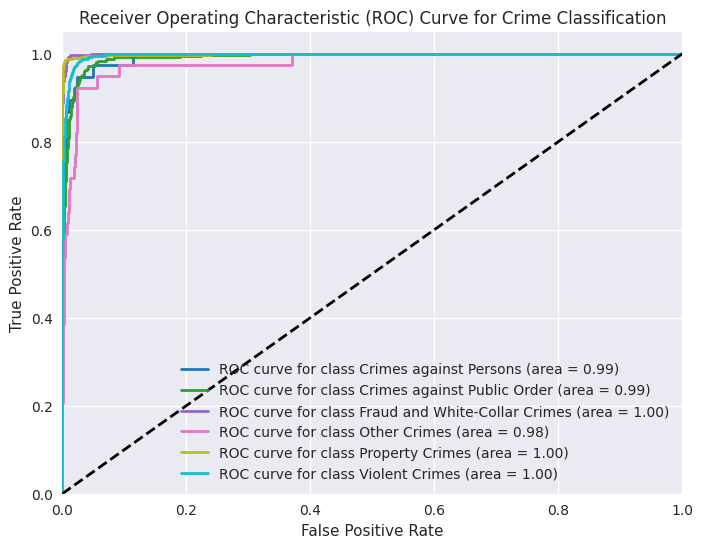

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Victim_Age',
                                                   'Hour_Occurred',
                                                   'Month_Occurred', 'Area_ID',
                                                   'Part 1-2',
                                                   'Weapon_Used_Code',
                                                   'Premise_Code',
                                                   'Victim_Involved',
                                                   'Occurred_on_crossstreet',
                                                   'Victim_Arrested',
                                                   'Days_elpased_to_report',
                                                   'Is_Ju...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Victim_Sex',
                                                   'Victim_Descent']),
                                                 ('modus',
                                                  ModusOperandiTransformer(),
                                                  'Modus_Operandi_Codes')])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.05, n_estimators=200,
                                num_class=6, num_leaves=40,
                                objective='multiclass', verbose=-1))])

In [92]:
# Define the preprocessing function
def preprocessing(train_df, test_df):

    # Drop duplicates
#     train_df.drop_duplicates(inplace=True)
    # Removing the values less that zero for the "Victim_Age" column
    # train_df.drop(train_df[train_df['Victim_Age'] < 0].index, axis=0, inplace=True)

    train_df['Victim_Sex'].replace('H', 'M', inplace=True)

    # Handling the outliers in the Victim_Age column
    Q1 = train['Victim_Age'].quantile(0.25)
    Q3 = train['Victim_Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df['Victim_Age'] >= lower_bound) & (train_df['Victim_Age'] <= upper_bound)]

    # We will replace the missing values with the median of the respective columns
    lat_col = train_df['Latitude'][train_df['Latitude'] != 0]
    long_col = train_df['Longitude'][train_df['Longitude'] != 0]

    train_df['Latitude'] = train_df['Latitude'].replace(0, lat_col.median())
    train_df['Longitude'] = train_df['Longitude'].replace(0, long_col.median())
    
    
    train_df['Weapon_Used_Code'] = train_df['Weapon_Used_Code'].fillna(train_df['Weapon_Used_Code'].max()+100)
    test_df['Weapon_Used_Code'] = test_df['Weapon_Used_Code'].fillna(train_df['Weapon_Used_Code'].max()+100)

    # We will replace the missing values with the median of the respective columns
    lat_col = test_df['Latitude'][test_df['Latitude'] != 0]
    long_col = test_df['Longitude'][test_df['Longitude'] != 0]
    test_df['Latitude'] = test_df['Latitude'].replace(0, lat_col.median())
    test_df['Longitude'] = test_df['Longitude'].replace(0, long_col.median())
    
    train_df['Location'] = train_df['Location'].replace('  +',' ',regex=True)
    test_df['Location'] = test_df['Location'].replace('  +',' ',regex=True)
    
    # Creating new features
    train_df['Hour_Occurred'] = (train_df['Time_Occurred'] // 100).astype(int)
    train_df['Month_Occurred'] = pd.to_datetime(train_df['Date_Reported']).dt.month
    test_df['Hour_Occurred'] = (test_df['Time_Occurred'] // 100).astype(int)
    test_df['Month_Occurred'] = pd.to_datetime(test_df['Date_Reported']).dt.month
    train_df['Victim_Arrested'] = train_df['Status'].apply(lambda status : status == 'AA' or status == 'JA')
    test_df['Victim_Arrested'] = test_df['Status'].apply(lambda status : status == 'AA' or status == 'JA')
    train_df['Is_Juvenile'] = test_df['Status'].apply(lambda status : status == 'JA' or status == 'JO')
    test_df['Is_Juvenile'] = test_df['Status'].apply(lambda status : status == 'JA' or status == 'JO')
    train_df['Occurred_on_crossstreet'] = train_df['Cross_Street'].apply(lambda x : 0 if x is np.nan else 1)
    test_df['Occurred_on_crossstreet'] = test_df['Cross_Street'].apply(lambda x : 0 if x is np.nan else 1)
    train_df['Victim_Involved'] = train_df['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)
    test_df['Victim_Involved'] = test_df['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)
    train_df['Days_elpased_to_report'] = (pd.to_datetime(train_df['Date_Reported']) - pd.to_datetime(train_df['Date_Occurred'])).dt.days
    test_df['Days_elpased_to_report'] = (pd.to_datetime(test_df['Date_Reported']) - pd.to_datetime(test_df['Date_Occurred'])).dt.days
    train_df['Week_Day'] = (pd.to_datetime(train_df['Date_Occurred'])).dt.weekday
    test_df['Week_Day'] = (pd.to_datetime(test_df['Date_Occurred'])).dt.weekday
    train_df['Day_Reported'] = (pd.to_datetime(train_df['Date_Reported'])).dt.day
    test_df['Day_Reported'] = (pd.to_datetime(test_df['Date_Reported'])).dt.day
    train_df['DayOfYear'] = (pd.to_datetime(train_df['Date_Occurred'])).dt.dayofyear
    test_df['DayOfYear'] = (pd.to_datetime(test_df['Date_Occurred'])).dt.dayofyear
    # Preprocess Modus Operandi column
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi'].str.split()
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi'].str.split()
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

    return train_df, test_df

# Define the custom transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

# Define the model training function
def train_model(train_data, test_data, model=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')):
    train_data, test_data = preprocessing(train_data, test_data)

    categorical_features = ['Victim_Sex', 'Victim_Descent', 'Status', 'Location']
    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code',
                         'Victim_Involved', 'Occurred_on_crossstreet', 'Victim_Arrested', 'Days_elpased_to_report', 'Is_Juvenile', 'Week_Day', 'Day_Reported', 'DayOfYear']

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y.values.reshape(-1,1))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent']),
#             ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])
    
    # Without SMOTE
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', model)
#     ])
     # Create and combine preprocessing and modeling pipeline with SMOTE

    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])


    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    print(f'Cross-validation Accuracy: {cv_scores.mean():.5f} ± {cv_scores.std():.5f}')

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.5f}')
    
                

    # Classification report
#     print("\nClassification Report:")
#     print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
                

    # Confusion matrix
#     conf_matrix = confusion_matrix(y_val, y_pred)
#     plt.figure(figsize=(4, 3))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#                 xticklabels=label_encoder.classes_, 
#                 yticklabels=label_encoder.classes_)
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title('Confusion Matrix')
#     plt.show()
                
    # Plot ROC Curve
    n_classes = len(label_encoder.classes_)
    plot_multiclass_roc(pipeline, X_val, y_val, n_classes, label_encoder)

    # Predict on the test data
    test_preds = pipeline.predict(test_data)
    decoded_y_preds = label_encoder.inverse_transform(test_preds)

    make_submission(decoded_y_preds)

    return pipeline

def make_submission(predictions):
    submission = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'Crime_Category': predictions})
    submission.to_csv('submission.csv', index=False)

train, test = load_dataset(running_env)

# print('Bagging Classifier')
# bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_split=5), n_estimators=50, random_state=42)
# train_model(train, test, bagging_model)

# print('XGBClassifier')
# xgBoost_model = XGBClassifier(colsample_bytree = 0.8, learning_rate = 0.1,max_depth = 7, n_estimators = 100, classifier__subsample = 1.0)
# train_model(train, test, xgBoost_model)
# Hyper Parameter tunning results for XGBoostClassifier: Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

print('LGBMClassifier')
lbgm_model = lgb.LGBMClassifier(objective='multiclass', num_class=6, boosting_type='gbdt', learning_rate= 0.05, n_estimators= 200, num_leaves= 40, verbose= -1)
train_model(train, test, lbgm_model)

# print('LGBMClassifier')
# lbgm_model = lgb.LGBMClassifier(objective='multiclass', num_class=6, boosting_type='gbdt', learning_rate= 0.1, n_estimators= 100, num_leaves= 40, verbose= -1)
# train_model(train, test, lbgm_model)

### Try Feature Elimination technique on Random Forest Estimator 

In [93]:
# Define the preprocessing function
def preprocessing(train_df, test_df):

    # Drop duplicates
    train_df.drop_duplicates(inplace=True)
    # Removing the values less that zero for the "Victim_Age" column
    # train_df.drop(train_df[train_df['Victim_Age'] < 0].index, axis=0, inplace=True)

    train_df['Victim_Sex'].replace('H', 'M', inplace=True)

    # Handling the outliers in the Victim_Age column
    Q1 = train['Victim_Age'].quantile(0.25)
    Q3 = train['Victim_Age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df['Victim_Age'] >= lower_bound) & (train_df['Victim_Age'] <= upper_bound)]

    # We will replace the missing values with the median of the respective columns
    lat_col = train_df['Latitude'][train_df['Latitude'] != 0]
    long_col = train_df['Longitude'][train_df['Longitude'] != 0]

    train_df['Latitude'] = train_df['Latitude'].replace(0, lat_col.median())
    train_df['Longitude'] = train_df['Longitude'].replace(0, long_col.median())
    
    
    train_df['Weapon_Used_Code'] = train_df['Weapon_Used_Code'].fillna(train_df['Weapon_Used_Code'].max()+100)
    test_df['Weapon_Used_Code'] = test_df['Weapon_Used_Code'].fillna(train_df['Weapon_Used_Code'].max()+100)

    # We will replace the missing values with the median of the respective columns
    lat_col = test_df['Latitude'][test_df['Latitude'] != 0]
    long_col = test_df['Longitude'][test_df['Longitude'] != 0]
    test_df['Latitude'] = test_df['Latitude'].replace(0, lat_col.median())
    test_df['Longitude'] = test_df['Longitude'].replace(0, long_col.median())
    
    train_df['Location'] = train_df['Location'].replace('  +',' ',regex=True)
    test_df['Location'] = test_df['Location'].replace('  +',' ',regex=True)
    
    # Creating new features
    train_df['Hour_Occurred'] = (train_df['Time_Occurred'] // 100).astype(int)
    train_df['Month_Occurred'] = pd.to_datetime(train_df['Date_Reported']).dt.month
    test_df['Hour_Occurred'] = (test_df['Time_Occurred'] // 100).astype(int)
    test_df['Month_Occurred'] = pd.to_datetime(test_df['Date_Reported']).dt.month
    train_df['Victim_Arrested'] = train_df['Status'].apply(lambda status : status == 'AA' or status == 'JA')
    test_df['Victim_Arrested'] = test_df['Status'].apply(lambda status : status == 'AA' or status == 'JA')
    train_df['Is_Juvenile'] = test_df['Status'].apply(lambda status : status == 'JA' or status == 'JO')
    test_df['Is_Juvenile'] = test_df['Status'].apply(lambda status : status == 'JA' or status == 'JO')
    train_df['Occurred_on_crossstreet'] = train_df['Cross_Street'].apply(lambda x : 0 if x is np.nan else 1)
    test_df['Occurred_on_crossstreet'] = test_df['Cross_Street'].apply(lambda x : 0 if x is np.nan else 1)
    train_df['Victim_Involved'] = train_df['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)
    test_df['Victim_Involved'] = test_df['Victim_Age'].apply(lambda x : 0 if x <= 0 else 1)
    train_df['Days_elpased_to_report'] = (pd.to_datetime(train_df['Date_Reported']) - pd.to_datetime(train_df['Date_Occurred'])).dt.days
    test_df['Days_elpased_to_report'] = (pd.to_datetime(test_df['Date_Reported']) - pd.to_datetime(test_df['Date_Occurred'])).dt.days
    train_df['Week_Day'] = (pd.to_datetime(train_df['Date_Occurred'])).dt.weekday
    test_df['Week_Day'] = (pd.to_datetime(test_df['Date_Occurred'])).dt.weekday
    train_df['Day_Reported'] = (pd.to_datetime(train_df['Date_Reported'])).dt.day
    test_df['Day_Reported'] = (pd.to_datetime(test_df['Date_Reported'])).dt.day
    train_df['DayOfYear'] = (pd.to_datetime(train_df['Date_Occurred'])).dt.dayofyear
    test_df['DayOfYear'] = (pd.to_datetime(test_df['Date_Occurred'])).dt.dayofyear
    # Preprocess Modus Operandi column
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi'].str.split()
    train_df['Modus_Operandi_Codes'] = train_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi'].str.split()
    test_df['Modus_Operandi_Codes'] = test_df['Modus_Operandi_Codes'].apply(lambda x: x if isinstance(x, list) else [])

    return train_df, test_df

# Define the custom transformer for Modus Operandi
class ModusOperandiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self

    def transform(self, X):
        return self.mlb.transform(X)

# Define the model training function
def train_model(train_data, test_data, model=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')):
    train_data, test_data = preprocessing(train_data, test_data)

    categorical_features = ['Victim_Sex', 'Victim_Descent', 'Status', 'Location']
    numerical_features = ['Latitude', 'Victim_Age', 'Hour_Occurred', 'Month_Occurred', 'Area_ID', 'Part 1-2', 'Weapon_Used_Code', 'Premise_Code',
                         'Victim_Involved', 'Occurred_on_crossstreet', 'Victim_Arrested', 'Days_elpased_to_report', 'Is_Juvenile', 'Week_Day', 'Day_Reported', 'DayOfYear']

    X = train_data.drop('Crime_Category', axis=1)
    y = train_data['Crime_Category']

    # Encoding target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y.values.reshape(-1,1))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing for numerical features: imputation and scaling
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define preprocessing for categorical features: imputation and encoding
    categorical_transformer_one_hot = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    categorical_transformer_ordinal = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat_one_hot', categorical_transformer_one_hot, ['Victim_Sex', 'Victim_Descent']),
            ('cat_ordinal', categorical_transformer_ordinal, ['Location']),
            ('modus', ModusOperandiTransformer(), 'Modus_Operandi_Codes')
        ])
    
    # Define the RFE step
    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator, n_features_to_select=10, step=1)
    
    # Without SMOTE
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
     # Create and combine preprocessing and modeling pipeline with SMOTE

#     pipeline = ImbPipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('smote', SMOTE(random_state=42)),
#         ('classifier', model)
#     ])


    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    print(f'Cross-validation Accuracy: {cv_scores.mean():.5f} ± {cv_scores.std():.5f}')

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Accuracy: {accuracy:.5f}')
    
                

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
                

    # Confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
                
    # Plot ROC Curve
    n_classes = len(label_encoder.classes_)
    plot_multiclass_roc(pipeline, X_val, y_val, n_classes, label_encoder)

    # Predict on the test data
    test_preds = pipeline.predict(test_data)
    decoded_y_preds = label_encoder.inverse_transform(test_preds)

    make_submission(decoded_y_preds)

    return pipeline

def make_submission(predictions):
    submission = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'Crime_Category': predictions})
    submission.to_csv('submission.csv', index=False)

# train, test = load_dataset(running_env)

# print('RandomForestClassifier')
# random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
# train_model(train, test, random_forest_model)


Advantages of LightGBM
* Speed and Efficiency: Faster training times and lower memory usage compared to other gradient boosting frameworks like XGBoost and CatBoost.
* Scalability: Effective for handling large datasets and high-dimensional features.
* Flexibility: Supports various types of data and tasks, with built-in regularization and tuning options.

#### Based on experimentation with the three machine learning models: Bagging with Decision Trees, XGBoost, and LightGBM, let's compare their performances and provide insights on their results.

Model Summary
----
1. Bagging with Decision Trees

- Model: BaggingClassifier using DecisionTreeClassifier
- Hyperparameters:
- Base Estimator: DecisionTreeClassifier
- Max Depth: None
- Min Samples Split: 5
- Number of Estimators: 50
- Random State: 42
- Validation Accuracy: 0.95125
2. XGBoost

- Model: XGBClassifier
- Hyperparameters:
- Colsample by Tree: 0.8
- Learning Rate: 0.1
- Max Depth: 7
- Number of Estimators: 100
- Subsample: 1.0
- Validation Accuracy: 0.95775
- LightGBM

3. Model: LGBMClassifier
- Hyperparameters:
- Objective: multiclass
- Number of Classes: 6
- Boosting Type: gbdt
- Learning Rate: 0.1
- Number of Estimators: 150
- Number of Leaves: 31
- Verbose: -1
- Validation Accuracy: 0.96100

| Model                       | Validation Accuracy | Speed (Training) | Interpretability | Use Cases                                                                               |
|-----------------------------|---------------------|------------------|------------------|-----------------------------------------------------------------------------------------|
| Bagging with Decision Trees | 0.95125             | Moderate         | High             | Suitable for datasets with less complexity; provides robustness against overfitting.    |
| XGBoost                     | 0.95775             | Fast             | Moderate         | Effective for structured data; excels in handling non-linear relationships.             |
| LightGBM                    | 0.96100             | Very Fast        | Moderate         | Highly efficient with large datasets; can handle categorical features natively.         |


Insights
---
1. Accuracy:

- LightGBM achieved the highest validation accuracy of 0.96100, followed by XGBoost with 0.95775, and Bagging with 0.95125.
- The slight differences in accuracy indicate that all models perform well, but LightGBM has a slight edge in this particular setting.
2. Training Speed:

- LightGBM is known for its efficiency and speed, especially with large datasets, due to its leaf-wise tree growth strategy.
- XGBoost also performs efficiently and can be optimized with hyperparameter tuning to balance accuracy and speed.
- Bagging with Decision Trees is generally slower due to the ensemble of decision trees but can be optimized further by adjusting the number of estimators or other tree parameters.
3. Interpretability:

- Bagging provides more interpretability compared to the boosting models as it uses decision trees, which can be visualized and easily understood.
- XGBoost and LightGBM offer feature importance measures, but the models themselves are less interpretable due to the complexity of ensemble methods.
4. Use Cases:

- LightGBM is particularly useful for large datasets with many features, including categorical ones, as it handles them efficiently.
- XGBoost is a versatile model widely used in competitions and real-world applications for its robustness and ability to capture complex patterns.
- Bagging is beneficial when you want to reduce variance and prevent overfitting with relatively simple models.

Conclusion
---
- LightGBM stands out as the best performer in this experiment due to its highest accuracy and efficient training speed, making it an excellent choice for large and complex datasets.
- XGBoost remains a strong contender, offering slightly lower accuracy but still delivering robust performance and efficient handling of structured data.
- Bagging with Decision Trees is a reliable model for scenarios where interpretability and robustness against overfitting are important, but it might lag in accuracy compared to boosting methods.


In summary, choosing the right model depends on the specific requirements of your task, such as the importance of interpretability, speed, and the complexity of the data. For maximum accuracy and efficiency, LightGBM is recommended, while XGBoost provides a good balance between performance and interpretability.

# Thank you